## Natural Language Processing (NLP) | Course Project - Part 3

##### Esra Sekerci - 2698215
---

Natural Language Processing (NLP)
Your second deliverable in the NLP track of the project is concerned with text classification and how the data representation can affect it given a data set. You will use the same Turkish data set provided in this link. You are supposed to represent the text data using different methods, build some non-linear feedforward deep learning architectures, train three different models with the same data being represented differently to do a classification task on this data set by using pytorch and see if the performance changes. Evaluate the situation in general and discuss why and how the given techniques impacts the performance if there is any. If not, discuss why there is not much of a change in the performance.

Firstly, you need to select a non-linear feedforward deep learning architecture with some hidden layers for text classification. The following links can help with the architecture: link 1, link 2, link 3. Note that these architectures are to be modified to your needs and the last one presents a non-linear feedforward architecture.

Afterwards, you will use three different ways of data representation and train the model (the architecture above) from scratch with each representation, and compare their performances. These three representations are:

A representation similar to the bag of words that we have seen in class, but with binary values: The values are False (0) for non-existent linguistic items and True (1) for existent linguistic items: The idea is explained in
Play Video
. This link can help with how to implement bag of words with Pytorch.
Use the bag of words exactly like we have seen in the class.
Use embeddings. The architecture in this link can give some ideas how to have an embedding layer.
You will compare the overall accuracy scores you obtained from these three alternative representations. In order to make a comparison, you are expected to use the same architecture with the same hyperparameters with the same data being input into the model with each of those representations. You need to train the model from scratch with each representation (in order to compare)

Finally train another alternative non-linear feedforward deep learning architectures with some hidden layers, and repeat the steps above with that structure. Try to improve the performance. You may change the number of hidden layers, the activation function or work on hyperparameters. Follow the same steps as above with the new architecture.

Describe your steps using text boxes and code comments when necessary. All your analysis and report should be in a Jupyter Notebook.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import nltk
import ssl
from nltk import word_tokenize,sent_tokenize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from snowballstemmer import TurkishStemmer
from zeyrek import MorphAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import string
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from collections import defaultdict
from nltk.tokenize import word_tokenize

In [3]:
data_dir = r"/Users/esrasekerci/Desktop/42bin_haber/news"

def read_text(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        text = file.read()
    return text

dataset_rows = []

for subdir, _, files in os.walk(data_dir):
    folder_name = os.path.basename(subdir)
    for file in files:
        file_path = os.path.join(subdir, file)
        text = read_text(file_path)
        dataset_rows.append((text, folder_name))

df = pd.DataFrame(dataset_rows, columns=['text', 'category'])
df = df[df['category'] != 'news']
df.head()

,text,category
1,"""Özel sektör yapmazsa biz yaparız""\nEkonomi Ba...",ekonomi
2,Turizimde gelir artışı\n \n Türkiye’nin 2012 y...,ekonomi
3,Apple'ın yerini Google alabilir\nSon yıllarda ...,ekonomi
4,"ING, 2 bin 400 kişiyi işten çıkaracak\nHolland...",ekonomi
5,Okmeydanı Hastanesi için geri sayım başladı\nİ...,ekonomi


In [4]:
#df = df[~df['category'].isin(['teknoloji', 'yasam','siyaset', 'guncel', 'planet', 'magazin', 'turkiye', 'genel'])]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41992 entries, 1 to 41992
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      41992 non-null  object
 1   category  41992 non-null  object
dtypes: object(2)
memory usage: 984.2+ KB


In [6]:
df['category'].value_counts()

category
spor            9997
genel           6673
guncel          5847
dunya           3724
ekonomi         3265
magazin         2792
planet          1953
turkiye         1939
siyaset         1849
saglik          1383
kultur-sanat    1155
teknoloji        771
yasam            644
Name: count, dtype: int64

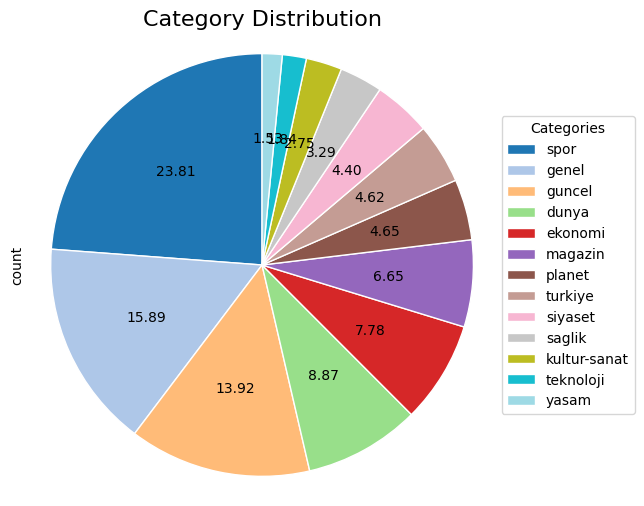

In [7]:
# Generate a color map with unique colors for each category
unique_categories = df['category'].nunique()
cmap = plt.get_cmap('tab20', unique_categories)

# Create the pie chart
fig, ax = plt.subplots(figsize=(6,6))
df['category'].value_counts().plot.pie(
    autopct='%1.2f', 
    startangle=90,
    colors=[cmap(i) for i in range(unique_categories)],
    wedgeprops={'edgecolor': 'white'},
    labels=None
)

ax.set_title('Category Distribution', fontsize=16)

ax.legend(
    df['category'].value_counts().index, 
    title="Categories", 
    loc="center left", 
    bbox_to_anchor=(1, 0.5)
)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

plt.show()

In [8]:
# Sample a smaller subset while maintaining label distribution
# df = df.groupby('category').apply(lambda x: x.sample(n=min(1000, len(x)), random_state=42)).reset_index(drop=True)

##### Data Preprocessing and Representation

In [9]:
df_1 = df.copy()

In [10]:
# Cleaning stopwords
def clean_stopwords(content):
    # Get NLTK Turkish stopwords
    nltk_stopwords = set(stopwords.words("turkish"))
    
    # Split content into words, filter out stopwords, and join back into a string
    return ' '.join(word for word in content.split() if word not in nltk_stopwords)


#  cleaning URLs
def clean_url(content):
    #  content: str
    #  return: str
    reg_url = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
    pattern_url = re.compile(reg_url)
    content = pattern_url.sub('',content)
    return content
    
#  cleaning e-mails
def clean_email(content):
    reg_email='\S*@\S*\s?'
    pattern_email = re.compile(reg_email)
    content = pattern_email.sub('',content)
    return content
    
#  cleaning punctuation
def clean_punctuation(content):
    #regex = re.compile('[%s]' % re.escape(string.punctuation))
    #content = regex.sub(" ", content)
    content = content.translate(content.maketrans("", "", string.punctuation))
    return content
    
#  cleaning digits
def clean_numbers(content):
    remove_digits = str.maketrans('', '', string.digits)
    text = content.translate(remove_digits)
    return text

def listToString(text):
    #  text: string
    #  return: string 
    str1 = " "  
    return (str1.join(text)) 

def clean_postfix(content):
    #  content: list
    #  return: str
    spesific_punctation = [39, 8217] # ascii codes of spesific punctations
    all_words = defaultdict(list)
    counter = 0
    for i, word in enumerate(content):
        if len(word) > 2:
            if chr(8217) in word:
                replaced_word = word.replace(chr(8217), " ")
                replaced_word = replaced_word.split(" ")[0]
                all_words[i].append(replaced_word)
            elif chr(39) in word:
                replaced_word = word.replace(chr(39), " ")
                replaced_word = replaced_word.split(" ")[0]
                all_words[i].append(replaced_word)
            else:
                all_words[i].append(word)
    all_words = sorted(all_words.items())

    text = ""
    for i in range(len(all_words)):
        text = text + " " + all_words[i][1][0]

    return text

def clean_text(content):
    #  text: string
    #  return: string
    content = content.lower()
    content = re.sub(r'\x93', '', content)
    content = re.sub(r'\x94', '', content)
    content = re.sub(r'', ' ', content)
    cleaned_email = clean_email(content)
    cleaned_email_url = clean_url(cleaned_email)
    cleaned_email_url = listToString(cleaned_email_url.split("."))
    cleaned_email_url = cleaned_email_url.split(" ")
    cleaned_email_url_postfix = clean_postfix(cleaned_email_url)
    cleaned_email_url_postfix_punctuation = clean_punctuation(cleaned_email_url_postfix)
    cleaned_email_url_postfix_punctuation_numbers = clean_numbers(cleaned_email_url_postfix_punctuation)
    cleaned_email_url_postfix_punctuation_numbers_stopwords = clean_stopwords(cleaned_email_url_postfix_punctuation_numbers)
   
    filtered_sentence = []
    for word in cleaned_email_url_postfix_punctuation_numbers_stopwords.split(" "):
        if len(word) > 2:
            filtered_sentence.append(word)
    
    text = ' '.join(filtered_sentence)
    return text

In [11]:
cleaning = lambda x: clean_text(x)
df_1['clean_text'] = df_1['text'].apply(cleaning)

In [12]:
df_1

,text,category,clean_text
1,"""Özel sektör yapmazsa biz yaparız""\nEkonomi Ba...",ekonomi,özel sektör yapmazsa yaparız ekonomi bakanı za...
2,Turizimde gelir artışı\n \n Türkiye’nin 2012 y...,ekonomi,turizimde gelir artışı türkiye yılında turizmd...
3,Apple'ın yerini Google alabilir\nSon yıllarda ...,ekonomi,apple yerini google alabilir son yıllarda fina...
4,"ING, 2 bin 400 kişiyi işten çıkaracak\nHolland...",ekonomi,ing bin kişiyi işten çıkaracak hollanda merkez...
5,Okmeydanı Hastanesi için geri sayım başladı\nİ...,ekonomi,okmeydanı hastanesi geri sayım başladı i̇stanb...
...,...,...,...
41988,"Diyanet'ten kıyamet söylentilerine yanıt\n""Bat...",turkiye,diyanet kıyamet söylentilerine yanıt batıl sah...
41989,TSK'dan intihar açıklaması\nGenelkurmay Başkan...,turkiye,tsk intihar açıklaması genelkurmay başkanlığı ...
41990,Taşucu Gümrüğü'nde cephanelik gibi araç bulund...,turkiye,taşucu gümrüğü cephanelik araç bulundu mersin ...
41991,Yolcu kapma yarışı: 10 yaralı\n \n İstanbul Ka...,turkiye,yolcu kapma yarışı yaralı i̇stanbul kartal yol...


In [13]:
text_list = df_1['clean_text'].tolist()

In [14]:
unique_words_set = set()
for text in text_list:
    words = text.split()
    unique_words_set.update(words)

num_unique_words = len(unique_words_set)
print("Number of unique words:", num_unique_words)

Number of unique words: 320866


In [15]:
from sklearn.utils import shuffle
# Shuffle the DataFrame
df_1 = shuffle(df_1, random_state=42).reset_index(drop=True)

In [16]:
label_encoder = LabelEncoder()
df_1['class_index'] = label_encoder.fit_transform(df_1['category'])

In [17]:
df_1.head()

,text,category,clean_text,class_index
0,Üsküdar namağlup devam ediyor\nHentbol Bayanla...,spor,üsküdar namağlup devam ediyor hentbol bayanlar...,9
1,Putin'den 'hazır olmalıyız' uyarısı\nRusya Dev...,dunya,putin olmalıyız uyarısı rusya devlet başkanı v...,0
2,Boğaz'da lüks tekne yandı: 2 ölü\nBeşiktaş'tak...,guncel,boğaz lüks tekne yandı ölü beşiktaş yat limanı...,3
3,Sizi kim sildi?\nFacebook'ta sizi arkadaş list...,teknoloji,sizi sildi facebook sizi arkadaş listesinden k...,10
4,Ömer & Harden ortaklığı galibiyet getirdi\nHou...,spor,ömer harden ortaklığı galibiyet getirdi housto...,9


In [18]:
from tqdm import tqdm
from nltk.tokenize import word_tokenize
# Initialize tqdm for pandas
tqdm.pandas()

# Tokenize the text and add progress bar
df_1['tokens'] = df_1['clean_text'].progress_map(word_tokenize)

print(df_1)

100%|██████████| 41992/41992 [00:21<00:00, 1967.03it/s]

                                                    text   category  \
0      Üsküdar namağlup devam ediyor\nHentbol Bayanla...       spor   
1      Putin'den 'hazır olmalıyız' uyarısı\nRusya Dev...      dunya   
2      Boğaz'da lüks tekne yandı: 2 ölü\nBeşiktaş'tak...     guncel   
3      Sizi kim sildi?\nFacebook'ta sizi arkadaş list...  teknoloji   
4      Ömer & Harden ortaklığı galibiyet getirdi\nHou...       spor   
...                                                  ...        ...   
41987  Aşksız olmaz\nZiynet Sali, menajeriyle birlikt...    magazin   
41988  Magazin dünyasında bomba iddia!\nLife & Style ...      genel   
41989  Futbolun Obama'sı hoş geldin\nAlmanya Bundesli...       spor   
41990  Bakandan arama motoru sitelerine tepki\n"Bir t...    ekonomi   
41991  İstiridye mantarı ye, kilo ver!\n \n Gaziosman...     saglik   

                                              clean_text  class_index  \
0      üsküdar namağlup devam ediyor hentbol bayanlar...            9   
1

In [19]:
df_1

,text,category,clean_text,class_index,tokens
0,Üsküdar namağlup devam ediyor\nHentbol Bayanla...,spor,üsküdar namağlup devam ediyor hentbol bayanlar...,9,"[üsküdar, namağlup, devam, ediyor, hentbol, ba..."
1,Putin'den 'hazır olmalıyız' uyarısı\nRusya Dev...,dunya,putin olmalıyız uyarısı rusya devlet başkanı v...,0,"[putin, olmalıyız, uyarısı, rusya, devlet, baş..."
2,Boğaz'da lüks tekne yandı: 2 ölü\nBeşiktaş'tak...,guncel,boğaz lüks tekne yandı ölü beşiktaş yat limanı...,3,"[boğaz, lüks, tekne, yandı, ölü, beşiktaş, yat..."
3,Sizi kim sildi?\nFacebook'ta sizi arkadaş list...,teknoloji,sizi sildi facebook sizi arkadaş listesinden k...,10,"[sizi, sildi, facebook, sizi, arkadaş, listesi..."
4,Ömer & Harden ortaklığı galibiyet getirdi\nHou...,spor,ömer harden ortaklığı galibiyet getirdi housto...,9,"[ömer, harden, ortaklığı, galibiyet, getirdi, ..."
...,...,...,...,...,...
41987,"Aşksız olmaz\nZiynet Sali, menajeriyle birlikt...",magazin,aşksız olmaz ziynet sali menajeriyle birlikte ...,5,"[aşksız, olmaz, ziynet, sali, menajeriyle, bir..."
41988,Magazin dünyasında bomba iddia!\nLife & Style ...,genel,magazin dünyasında bomba iddia life style derg...,2,"[magazin, dünyasında, bomba, iddia, life, styl..."
41989,Futbolun Obama'sı hoş geldin\nAlmanya Bundesli...,spor,futbolun obama hoş geldin almanya bundesliga l...,9,"[futbolun, obama, hoş, geldin, almanya, bundes..."
41990,"Bakandan arama motoru sitelerine tepki\n""Bir t...",ekonomi,bakandan arama motoru sitelerine tepki bir tek...,1,"[bakandan, arama, motoru, sitelerine, tepki, b..."


In [42]:
# Create vocabulary and mappings
threshold = 10
tokens = df_1['tokens'].explode().value_counts()
tokens = tokens[tokens > threshold]
id_to_token = ['[UNK]'] + tokens.index.tolist()
token_to_id = {w: i for i, w in enumerate(id_to_token)}
vocabulary_size = len(id_to_token)
print(f'Vocabulary size: {vocabulary_size}')

Vocabulary size: 57448


In [21]:
# Convert features to a suitable format for modeling
def make_features(tokens, unk_id=0):
    vector = {token_to_id.get(t, unk_id): 1 for t in tokens}
    return vector

df_1['features'] = df_1['tokens'].apply(make_features)
df_1

,text,category,clean_text,class_index,tokens,features
0,Üsküdar namağlup devam ediyor\nHentbol Bayanla...,spor,üsküdar namağlup devam ediyor hentbol bayanlar...,9,"[üsküdar, namağlup, devam, ediyor, hentbol, ba...","{4591: 1, 7857: 1, 28: 1, 147: 1, 5244: 1, 329..."
1,Putin'den 'hazır olmalıyız' uyarısı\nRusya Dev...,dunya,putin olmalıyız uyarısı rusya devlet başkanı v...,0,"[putin, olmalıyız, uyarısı, rusya, devlet, baş...","{2555: 1, 10441: 1, 3055: 1, 192: 1, 113: 1, 2..."
2,Boğaz'da lüks tekne yandı: 2 ölü\nBeşiktaş'tak...,guncel,boğaz lüks tekne yandı ölü beşiktaş yat limanı...,3,"[boğaz, lüks, tekne, yandı, ölü, beşiktaş, yat...","{4445: 1, 2765: 1, 11063: 1, 8487: 1, 1133: 1,..."
3,Sizi kim sildi?\nFacebook'ta sizi arkadaş list...,teknoloji,sizi sildi facebook sizi arkadaş listesinden k...,10,"[sizi, sildi, facebook, sizi, arkadaş, listesi...","{1553: 1, 30034: 1, 1184: 1, 2754: 1, 27608: 1..."
4,Ömer & Harden ortaklığı galibiyet getirdi\nHou...,spor,ömer harden ortaklığı galibiyet getirdi housto...,9,"[ömer, harden, ortaklığı, galibiyet, getirdi, ...","{590: 1, 10514: 1, 4701: 1, 705: 1, 314: 1, 34..."
...,...,...,...,...,...,...
41987,"Aşksız olmaz\nZiynet Sali, menajeriyle birlikt...",magazin,aşksız olmaz ziynet sali menajeriyle birlikte ...,5,"[aşksız, olmaz, ziynet, sali, menajeriyle, bir...","{0: 1, 810: 1, 13127: 1, 23120: 1, 48604: 1, 5..."
41988,Magazin dünyasında bomba iddia!\nLife & Style ...,genel,magazin dünyasında bomba iddia life style derg...,2,"[magazin, dünyasında, bomba, iddia, life, styl...","{8647: 1, 3896: 1, 1253: 1, 237: 1, 10741: 1, ..."
41989,Futbolun Obama'sı hoş geldin\nAlmanya Bundesli...,spor,futbolun obama hoş geldin almanya bundesliga l...,9,"[futbolun, obama, hoş, geldin, almanya, bundes...","{4420: 1, 426: 1, 3570: 1, 12649: 1, 203: 1, 5..."
41990,"Bakandan arama motoru sitelerine tepki\n""Bir t...",ekonomi,bakandan arama motoru sitelerine tepki bir tek...,1,"[bakandan, arama, motoru, sitelerine, tepki, b...","{34183: 1, 915: 1, 6393: 1, 13759: 1, 468: 1, ..."


In [22]:
# Split data into train and test
train_df, test_df = train_test_split(df_1, test_size=0.2, random_state=42, stratify=df_1['class_index'])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['class_index'])

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = np.zeros(vocabulary_size, dtype=np.float32)
        for k, v in self.data.iloc[index]['features'].items():
            features[k] = v
        label = self.data.iloc[index]['class_index']
        return torch.tensor(features), torch.tensor(label, dtype=torch.long)

# Initialize datasets and data loaders
train_dataset = MyDataset(train_df)
val_dataset = MyDataset(val_df)
test_dataset = MyDataset(test_df)
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [35]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from tqdm import tqdm

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super().__init__()
        layers = []
        for i in range(num_layers):
            if i == 0:
                layers.append(nn.Linear(input_dim, hidden_dim))
            else:
                layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

# Function to train and evaluate the model
def train_and_evaluate(model, train_loader, val_loader, test_loader, optimizer, criterion, device, n_epochs):
    best_val_auc_roc = 0
    best_model_state = None
    model.train()
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        # Training phase
        for X, y_true in tqdm(train_loader, desc='Training'):
            X, y_true = X.to(device), y_true.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y_true)
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_outputs = []
            val_targets = []
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_output = model(X_val)
                val_loss += criterion(val_output, y_val).item() * X_val.size(0)
                val_outputs.append(val_output)
                val_targets.append(y_val)

            val_loss /= len(val_loader.dataset)
            val_outputs = torch.cat(val_outputs, dim=0)
            val_targets = torch.cat(val_targets, dim=0)
            val_auc_roc = roc_auc_score(val_targets.cpu().numpy(), val_outputs.softmax(dim=1).cpu().numpy(), average='weighted', multi_class='ovr')
            print(f'Validation Loss: {val_loss:.4f}, Validation AUC-ROC: {val_auc_roc:.4f}')

            # Save the best model
            if val_auc_roc > best_val_auc_roc:
                best_val_auc_roc = val_auc_roc
                best_model_state = model.state_dict()

    # Testing phase with the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        test_outputs = []
        test_targets = []
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_output = model(X_test)
            test_outputs.append(test_output)
            test_targets.append(y_test)

        test_outputs = torch.cat(test_outputs, dim=0)
        test_targets = torch.cat(test_targets, dim=0)
        test_auc_roc = roc_auc_score(test_targets.cpu().numpy(), test_outputs.softmax(dim=1).cpu().numpy(), average='weighted', multi_class='ovr')

    return test_outputs, test_targets, test_auc_roc, best_model_state

# Set hyperparameters and device
input_dim = vocabulary_size
output_dim = len(df_1['category'].unique())
n_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

param_grid = {
    'hidden_dim': [256, 512],
    'num_layers': [2, 3],
    'lr': [1e-3, 1e-2],
    'dropout': [0.8, 0.5],
    'momentum': [0.9, 0.99],
    'weight_decay': [1e-2, 1e-4],
    'optimizer': ['adam', 'sgd']
}

# Initialize model and loss function
criterion = nn.CrossEntropyLoss()

best_overall_model_state = None
best_overall_auc_roc = 0
best_params = None

# Iterate over parameter grid
for params in ParameterGrid(param_grid):
    print(f'Training with parameters: {params}')
    
    # Extract parameters
    hidden_dim = params['hidden_dim']
    num_layers = params['num_layers']
    lr = params['lr']
    dropout = params['dropout']
    momentum = params['momentum']
    weight_decay = params['weight_decay']
    optimizer_type = params['optimizer']

    # Initialize model, optimizer, and loaders for this set of parameters
    model = Model(input_dim, hidden_dim, num_layers, output_dim, dropout).to(device)
    
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    
    # Train, validate, and test the model
    test_outputs, test_targets, test_auc_roc, best_model_state = train_and_evaluate(model, train_loader, val_loader, test_loader, optimizer, criterion, device, n_epochs)

    # Print final evaluation metrics
    print(f'Test AUC-ROC: {test_auc_roc:.4f}, Parameters: {params}')

    # Save the overall best model
    if test_auc_roc > best_overall_auc_roc:
        best_overall_auc_roc = test_auc_roc
        best_overall_model_state = best_model_state
        best_params = params

# Load the best overall model for final evaluation
if best_overall_model_state is not None:
    model = Model(input_dim, best_params['hidden_dim'], best_params['num_layers'], output_dim, best_params['dropout']).to(device)
    model.load_state_dict(best_overall_model_state)

# Print classification report and confusion matrix
test_preds = np.argmax(test_outputs.cpu().numpy(), axis=1)
test_targets_np = test_targets.cpu().numpy()
print(classification_report(test_targets_np, test_preds, target_names=label_encoder.classes_))
print(confusion_matrix(test_targets_np, test_preds))

# Save the best model and parameters for future use
torch.save({
    'model_state_dict': best_overall_model_state,
    'params': best_params
}, 'best_model.pth')

Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:15<00:00, 14.86it/s]


Validation Loss: 1.4817, Validation AUC-ROC: 0.8756
Epoch 2/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.14it/s]


Validation Loss: 1.2056, Validation AUC-ROC: 0.8960
Epoch 3/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.46it/s]


Validation Loss: 1.1651, Validation AUC-ROC: 0.8997
Epoch 4/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.06it/s]


Validation Loss: 1.1589, Validation AUC-ROC: 0.9049
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.02it/s]


Validation Loss: 1.1466, Validation AUC-ROC: 0.9041
Test AUC-ROC: 0.9085, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.28it/s]


Validation Loss: 1.2030, Validation AUC-ROC: 0.8955
Epoch 2/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.24it/s]


Validation Loss: 1.0032, Validation AUC-ROC: 0.9182
Epoch 3/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.96it/s]


Validation Loss: 1.1524, Validation AUC-ROC: 0.9161
Epoch 4/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.32it/s]


Validation Loss: 1.2250, Validation AUC-ROC: 0.9160
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.00it/s]


Validation Loss: 1.3535, Validation AUC-ROC: 0.9143
Test AUC-ROC: 0.9135, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.10it/s]


Validation Loss: 2.4397, Validation AUC-ROC: 0.6431
Epoch 2/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.63it/s]


Validation Loss: 2.3188, Validation AUC-ROC: 0.6332
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.28it/s]


Validation Loss: 2.2303, Validation AUC-ROC: 0.6986
Epoch 4/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.27it/s]


Validation Loss: 2.1228, Validation AUC-ROC: 0.7623
Epoch 5/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.13it/s]


Validation Loss: 2.0042, Validation AUC-ROC: 0.7742
Test AUC-ROC: 0.7756, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.44it/s]


Validation Loss: 2.4188, Validation AUC-ROC: 0.6332
Epoch 2/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.18it/s]


Validation Loss: 2.2857, Validation AUC-ROC: 0.6548
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.32it/s]


Validation Loss: 2.1906, Validation AUC-ROC: 0.7303
Epoch 4/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.23it/s]


Validation Loss: 2.0564, Validation AUC-ROC: 0.7725
Epoch 5/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.12it/s]


Validation Loss: 1.9475, Validation AUC-ROC: 0.7864
Test AUC-ROC: 0.7882, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.11it/s]


Validation Loss: 1.7593, Validation AUC-ROC: 0.8064
Epoch 2/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.60it/s]


Validation Loss: 1.4353, Validation AUC-ROC: 0.8608
Epoch 3/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.47it/s]


Validation Loss: 1.2700, Validation AUC-ROC: 0.8835
Epoch 4/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.21it/s]


Validation Loss: 1.2458, Validation AUC-ROC: 0.8897
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.10it/s]


Validation Loss: 1.2196, Validation AUC-ROC: 0.8946
Test AUC-ROC: 0.8962, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.71it/s]


Validation Loss: 1.6638, Validation AUC-ROC: 0.8367
Epoch 2/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.89it/s]


Validation Loss: 1.0545, Validation AUC-ROC: 0.9105
Epoch 3/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.90it/s]


Validation Loss: 1.1649, Validation AUC-ROC: 0.9089
Epoch 4/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.89it/s]


Validation Loss: 1.3500, Validation AUC-ROC: 0.9092
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.99it/s]


Validation Loss: 1.5515, Validation AUC-ROC: 0.9105
Test AUC-ROC: 0.9095, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.97it/s]


Validation Loss: 2.4307, Validation AUC-ROC: 0.5881
Epoch 2/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.17it/s]


Validation Loss: 2.3400, Validation AUC-ROC: 0.6146
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.56it/s]


Validation Loss: 2.2938, Validation AUC-ROC: 0.6174
Epoch 4/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.21it/s]


Validation Loss: 2.2689, Validation AUC-ROC: 0.6475
Epoch 5/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.03it/s]


Validation Loss: 2.2408, Validation AUC-ROC: 0.7011
Test AUC-ROC: 0.6983, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.88it/s]


Validation Loss: 2.4257, Validation AUC-ROC: 0.6102
Epoch 2/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.42it/s]


Validation Loss: 2.3343, Validation AUC-ROC: 0.6548
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.97it/s]


Validation Loss: 2.2845, Validation AUC-ROC: 0.6727
Epoch 4/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.41it/s]


Validation Loss: 2.2441, Validation AUC-ROC: 0.7152
Epoch 5/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.27it/s]


Validation Loss: 2.1638, Validation AUC-ROC: 0.7408
Test AUC-ROC: 0.7432, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.86it/s]


Validation Loss: 1.4493, Validation AUC-ROC: 0.8781
Epoch 2/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.04it/s]


Validation Loss: 1.2525, Validation AUC-ROC: 0.8926
Epoch 3/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.31it/s]


Validation Loss: 1.1800, Validation AUC-ROC: 0.9008
Epoch 4/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.06it/s]


Validation Loss: 1.1728, Validation AUC-ROC: 0.9022
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.08it/s]


Validation Loss: 1.1447, Validation AUC-ROC: 0.9037
Test AUC-ROC: 0.9072, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.88it/s]


Validation Loss: 1.2297, Validation AUC-ROC: 0.8913
Epoch 2/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.19it/s]


Validation Loss: 1.0066, Validation AUC-ROC: 0.9180
Epoch 3/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.10it/s]


Validation Loss: 1.1080, Validation AUC-ROC: 0.9164
Epoch 4/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.96it/s]


Validation Loss: 1.2105, Validation AUC-ROC: 0.9173
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.85it/s]


Validation Loss: 1.2800, Validation AUC-ROC: 0.9143
Test AUC-ROC: 0.9115, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.41it/s]


Validation Loss: 2.1813, Validation AUC-ROC: 0.7537
Epoch 2/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.62it/s]


Validation Loss: 1.8603, Validation AUC-ROC: 0.7836
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.91it/s]


Validation Loss: 1.7047, Validation AUC-ROC: 0.8323
Epoch 4/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.66it/s]


Validation Loss: 1.5440, Validation AUC-ROC: 0.8585
Epoch 5/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.56it/s]


Validation Loss: 1.3577, Validation AUC-ROC: 0.8808
Test AUC-ROC: 0.8851, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.47it/s]


Validation Loss: 2.1559, Validation AUC-ROC: 0.7748
Epoch 2/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.86it/s]


Validation Loss: 1.7941, Validation AUC-ROC: 0.8213
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.60it/s]


Validation Loss: 1.4653, Validation AUC-ROC: 0.8654
Epoch 4/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.80it/s]


Validation Loss: 1.2075, Validation AUC-ROC: 0.8946
Epoch 5/5


Training: 100%|██████████| 237/237 [01:12<00:00,  3.26it/s]


Validation Loss: 1.1083, Validation AUC-ROC: 0.9060
Test AUC-ROC: 0.9099, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [04:49<00:00,  1.22s/it] 


Validation Loss: 1.7614, Validation AUC-ROC: 0.7985
Epoch 2/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.84it/s]


Validation Loss: 1.4047, Validation AUC-ROC: 0.8633
Epoch 3/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.96it/s]


Validation Loss: 1.2951, Validation AUC-ROC: 0.8805
Epoch 4/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.82it/s]


Validation Loss: 1.2311, Validation AUC-ROC: 0.8917
Epoch 5/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.55it/s]


Validation Loss: 1.2093, Validation AUC-ROC: 0.8952
Test AUC-ROC: 0.8975, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.66it/s]


Validation Loss: 1.6162, Validation AUC-ROC: 0.8517
Epoch 2/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.64it/s]


Validation Loss: 1.0830, Validation AUC-ROC: 0.9075
Epoch 3/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.85it/s]


Validation Loss: 1.1225, Validation AUC-ROC: 0.9135
Epoch 4/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.81it/s]


Validation Loss: 1.3390, Validation AUC-ROC: 0.9114
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.03it/s]


Validation Loss: 1.5734, Validation AUC-ROC: 0.9087
Test AUC-ROC: 0.9072, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.88it/s]


Validation Loss: 2.2770, Validation AUC-ROC: 0.6553
Epoch 2/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.36it/s]


Validation Loss: 2.0619, Validation AUC-ROC: 0.7203
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.87it/s]


Validation Loss: 1.8754, Validation AUC-ROC: 0.7260
Epoch 4/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.10it/s]


Validation Loss: 1.8332, Validation AUC-ROC: 0.7413
Epoch 5/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.05it/s]


Validation Loss: 1.7923, Validation AUC-ROC: 0.7539
Test AUC-ROC: 0.7586, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.69it/s]


Validation Loss: 2.2677, Validation AUC-ROC: 0.7182
Epoch 2/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.20it/s]


Validation Loss: 1.9490, Validation AUC-ROC: 0.7593
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.73it/s]


Validation Loss: 1.8128, Validation AUC-ROC: 0.7847
Epoch 4/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.36it/s]


Validation Loss: 1.6960, Validation AUC-ROC: 0.8225
Epoch 5/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.83it/s]


Validation Loss: 1.4557, Validation AUC-ROC: 0.8590
Test AUC-ROC: 0.8634, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.12it/s]


Validation Loss: 1.6801, Validation AUC-ROC: 0.8484
Epoch 2/5


Training: 100%|██████████| 237/237 [03:23<00:00,  1.17it/s]


Validation Loss: 1.3268, Validation AUC-ROC: 0.8824
Epoch 3/5


Training: 100%|██████████| 237/237 [00:15<00:00, 14.83it/s]


Validation Loss: 1.3086, Validation AUC-ROC: 0.8841
Epoch 4/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.43it/s]


Validation Loss: 1.2725, Validation AUC-ROC: 0.8881
Epoch 5/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.53it/s]


Validation Loss: 1.2366, Validation AUC-ROC: 0.8908
Test AUC-ROC: 0.8936, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.87it/s]


Validation Loss: 1.6980, Validation AUC-ROC: 0.8479
Epoch 2/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.13it/s]


Validation Loss: 1.0846, Validation AUC-ROC: 0.9060
Epoch 3/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.00it/s]


Validation Loss: 1.1448, Validation AUC-ROC: 0.9070
Epoch 4/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.10it/s]


Validation Loss: 1.2129, Validation AUC-ROC: 0.9042
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.00it/s]


Validation Loss: 1.2551, Validation AUC-ROC: 0.9018
Test AUC-ROC: 0.9029, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.27it/s]


Validation Loss: 1.9015, Validation AUC-ROC: 0.7969
Epoch 2/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.58it/s]


Validation Loss: 1.6706, Validation AUC-ROC: 0.8506
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.33it/s]


Validation Loss: 1.4204, Validation AUC-ROC: 0.8765
Epoch 4/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.29it/s]


Validation Loss: 1.2587, Validation AUC-ROC: 0.8948
Epoch 5/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.38it/s]


Validation Loss: 1.1962, Validation AUC-ROC: 0.9002
Test AUC-ROC: 0.9035, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.13it/s]


Validation Loss: 1.8745, Validation AUC-ROC: 0.8057
Epoch 2/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.24it/s]


Validation Loss: 1.4747, Validation AUC-ROC: 0.8711
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.68it/s]


Validation Loss: 1.1837, Validation AUC-ROC: 0.9000
Epoch 4/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.39it/s]


Validation Loss: 1.0873, Validation AUC-ROC: 0.9114
Epoch 5/5


Training: 100%|██████████| 237/237 [00:11<00:00, 19.75it/s]


Validation Loss: 1.0575, Validation AUC-ROC: 0.9154
Test AUC-ROC: 0.9174, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.68it/s]


Validation Loss: 1.9215, Validation AUC-ROC: 0.7611
Epoch 2/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.10it/s]


Validation Loss: 1.3673, Validation AUC-ROC: 0.8734
Epoch 3/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.03it/s]


Validation Loss: 1.3151, Validation AUC-ROC: 0.8768
Epoch 4/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.78it/s]


Validation Loss: 1.3490, Validation AUC-ROC: 0.8769
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.84it/s]


Validation Loss: 1.2751, Validation AUC-ROC: 0.8845
Test AUC-ROC: 0.8862, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.09it/s]


Validation Loss: 2.0150, Validation AUC-ROC: 0.7078
Epoch 2/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.56it/s]


Validation Loss: 1.1739, Validation AUC-ROC: 0.8945
Epoch 3/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.69it/s]


Validation Loss: 1.1455, Validation AUC-ROC: 0.8993
Epoch 4/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.06it/s]


Validation Loss: 1.2063, Validation AUC-ROC: 0.8991
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.99it/s]


Validation Loss: 1.1609, Validation AUC-ROC: 0.9022
Test AUC-ROC: 0.9035, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.82it/s]


Validation Loss: 2.1148, Validation AUC-ROC: 0.7201
Epoch 2/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.34it/s]


Validation Loss: 1.8624, Validation AUC-ROC: 0.7499
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.62it/s]


Validation Loss: 1.7950, Validation AUC-ROC: 0.7670
Epoch 4/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.26it/s]


Validation Loss: 1.7470, Validation AUC-ROC: 0.7905
Epoch 5/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.01it/s]


Validation Loss: 1.7181, Validation AUC-ROC: 0.8149
Test AUC-ROC: 0.8198, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.66it/s]


Validation Loss: 1.9837, Validation AUC-ROC: 0.7257
Epoch 2/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.39it/s]


Validation Loss: 1.8330, Validation AUC-ROC: 0.8003
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.13it/s]


Validation Loss: 1.5775, Validation AUC-ROC: 0.8504
Epoch 4/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.38it/s]


Validation Loss: 1.3262, Validation AUC-ROC: 0.8847
Epoch 5/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.11it/s]


Validation Loss: 1.2004, Validation AUC-ROC: 0.8992
Test AUC-ROC: 0.9025, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.22it/s]


Validation Loss: 1.7039, Validation AUC-ROC: 0.8489
Epoch 2/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.65it/s]


Validation Loss: 1.3104, Validation AUC-ROC: 0.8823
Epoch 3/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.60it/s]


Validation Loss: 1.2934, Validation AUC-ROC: 0.8812
Epoch 4/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.46it/s]


Validation Loss: 1.2752, Validation AUC-ROC: 0.8848
Epoch 5/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.58it/s]


Validation Loss: 1.2413, Validation AUC-ROC: 0.8908
Test AUC-ROC: 0.8921, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.77it/s]


Validation Loss: 1.6391, Validation AUC-ROC: 0.8550
Epoch 2/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.15it/s]


Validation Loss: 1.0841, Validation AUC-ROC: 0.9069
Epoch 3/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.97it/s]


Validation Loss: 1.1299, Validation AUC-ROC: 0.9090
Epoch 4/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.18it/s]


Validation Loss: 1.2129, Validation AUC-ROC: 0.9060
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.12it/s]


Validation Loss: 1.2785, Validation AUC-ROC: 0.9030
Test AUC-ROC: 0.9060, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.02it/s]


Validation Loss: 1.6971, Validation AUC-ROC: 0.8249
Epoch 2/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.59it/s]


Validation Loss: 1.2441, Validation AUC-ROC: 0.8910
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.59it/s]


Validation Loss: 1.2247, Validation AUC-ROC: 0.8940
Epoch 4/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.20it/s]


Validation Loss: 1.2004, Validation AUC-ROC: 0.9022
Epoch 5/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.10it/s]


Validation Loss: 1.1733, Validation AUC-ROC: 0.9037
Test AUC-ROC: 0.9061, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.41it/s]


Validation Loss: 1.6021, Validation AUC-ROC: 0.8556
Epoch 2/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.71it/s]


Validation Loss: 1.0894, Validation AUC-ROC: 0.9063
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.39it/s]


Validation Loss: 1.1005, Validation AUC-ROC: 0.9130
Epoch 4/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.50it/s]


Validation Loss: 1.2999, Validation AUC-ROC: 0.9096
Epoch 5/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.16it/s]


Validation Loss: 1.3905, Validation AUC-ROC: 0.9090
Test AUC-ROC: 0.9099, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.69it/s]


Validation Loss: 1.9304, Validation AUC-ROC: 0.7755
Epoch 2/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.70it/s]


Validation Loss: 1.4228, Validation AUC-ROC: 0.8743
Epoch 3/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.12it/s]


Validation Loss: 1.3222, Validation AUC-ROC: 0.8747
Epoch 4/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.98it/s]


Validation Loss: 1.3659, Validation AUC-ROC: 0.8722
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.80it/s]


Validation Loss: 1.2958, Validation AUC-ROC: 0.8768
Test AUC-ROC: 0.8807, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.71it/s]


Validation Loss: 1.9787, Validation AUC-ROC: 0.7198
Epoch 2/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.17it/s]


Validation Loss: 1.1774, Validation AUC-ROC: 0.8917
Epoch 3/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.94it/s]


Validation Loss: 1.1418, Validation AUC-ROC: 0.8979
Epoch 4/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.02it/s]


Validation Loss: 1.1943, Validation AUC-ROC: 0.8999
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.09it/s]


Validation Loss: 1.1996, Validation AUC-ROC: 0.9027
Test AUC-ROC: 0.9046, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:13<00:00, 18.04it/s]


Validation Loss: 2.0222, Validation AUC-ROC: 0.7137
Epoch 2/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.34it/s]


Validation Loss: 1.7819, Validation AUC-ROC: 0.7569
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.38it/s]


Validation Loss: 1.7142, Validation AUC-ROC: 0.7901
Epoch 4/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.22it/s]


Validation Loss: 1.5747, Validation AUC-ROC: 0.8421
Epoch 5/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.17it/s]


Validation Loss: 1.4584, Validation AUC-ROC: 0.8595
Test AUC-ROC: 0.8661, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.80it/s]


Validation Loss: 1.9258, Validation AUC-ROC: 0.6933
Epoch 2/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.06it/s]


Validation Loss: 1.4091, Validation AUC-ROC: 0.8708
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.34it/s]


Validation Loss: 1.1567, Validation AUC-ROC: 0.9056
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.92it/s]


Validation Loss: 1.1681, Validation AUC-ROC: 0.9083
Epoch 5/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.41it/s]


Validation Loss: 1.3404, Validation AUC-ROC: 0.9049
Test AUC-ROC: 0.9056, Parameters: {'dropout': 0.8, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.51it/s]


Validation Loss: 1.2883, Validation AUC-ROC: 0.8912
Epoch 2/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.83it/s]


Validation Loss: 1.1970, Validation AUC-ROC: 0.8981
Epoch 3/5


Training: 100%|██████████| 237/237 [00:23<00:00, 10.07it/s]


Validation Loss: 1.1908, Validation AUC-ROC: 0.9000
Epoch 4/5


Training: 100%|██████████| 237/237 [00:23<00:00,  9.95it/s]


Validation Loss: 1.1707, Validation AUC-ROC: 0.9018
Epoch 5/5


Training: 100%|██████████| 237/237 [00:23<00:00, 10.09it/s]


Validation Loss: 1.1398, Validation AUC-ROC: 0.9048
Test AUC-ROC: 0.9058, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.56it/s]


Validation Loss: 1.1302, Validation AUC-ROC: 0.9013
Epoch 2/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.66it/s]


Validation Loss: 0.9961, Validation AUC-ROC: 0.9208
Epoch 3/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.73it/s]


Validation Loss: 1.1251, Validation AUC-ROC: 0.9155
Epoch 4/5


Training: 100%|██████████| 237/237 [00:25<00:00,  9.15it/s]


Validation Loss: 1.2682, Validation AUC-ROC: 0.9147
Epoch 5/5


Training: 100%|██████████| 237/237 [00:25<00:00,  9.34it/s]


Validation Loss: 1.3921, Validation AUC-ROC: 0.9114
Test AUC-ROC: 0.9099, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.14it/s]


Validation Loss: 2.4231, Validation AUC-ROC: 0.6531
Epoch 2/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.45it/s]


Validation Loss: 2.3037, Validation AUC-ROC: 0.6592
Epoch 3/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.46it/s]


Validation Loss: 2.2113, Validation AUC-ROC: 0.7215
Epoch 4/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.70it/s]


Validation Loss: 2.0957, Validation AUC-ROC: 0.7648
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.75it/s]


Validation Loss: 1.9891, Validation AUC-ROC: 0.7744
Test AUC-ROC: 0.7752, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.37it/s]


Validation Loss: 2.4214, Validation AUC-ROC: 0.6449
Epoch 2/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.58it/s]


Validation Loss: 2.2988, Validation AUC-ROC: 0.6553
Epoch 3/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.74it/s]


Validation Loss: 2.1972, Validation AUC-ROC: 0.7366
Epoch 4/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.66it/s]


Validation Loss: 2.0611, Validation AUC-ROC: 0.7759
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.54it/s]


Validation Loss: 1.9525, Validation AUC-ROC: 0.7862
Test AUC-ROC: 0.7880, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:25<00:00,  9.44it/s]


Validation Loss: 1.7067, Validation AUC-ROC: 0.8285
Epoch 2/5


Training: 100%|██████████| 237/237 [00:25<00:00,  9.32it/s]


Validation Loss: 1.2763, Validation AUC-ROC: 0.8846
Epoch 3/5


Training: 100%|██████████| 237/237 [00:25<00:00,  9.14it/s]


Validation Loss: 1.2606, Validation AUC-ROC: 0.8888
Epoch 4/5


Training: 100%|██████████| 237/237 [00:23<00:00, 10.03it/s]


Validation Loss: 1.2125, Validation AUC-ROC: 0.8943
Epoch 5/5


Training: 100%|██████████| 237/237 [00:23<00:00,  9.95it/s]


Validation Loss: 1.2079, Validation AUC-ROC: 0.8953
Test AUC-ROC: 0.8972, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:25<00:00,  9.39it/s]


Validation Loss: 1.4360, Validation AUC-ROC: 0.8725
Epoch 2/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.56it/s]


Validation Loss: 1.0414, Validation AUC-ROC: 0.9139
Epoch 3/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.71it/s]


Validation Loss: 1.1775, Validation AUC-ROC: 0.9144
Epoch 4/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.61it/s]


Validation Loss: 1.3244, Validation AUC-ROC: 0.9104
Epoch 5/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.63it/s]


Validation Loss: 1.6559, Validation AUC-ROC: 0.9093
Test AUC-ROC: 0.9061, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.05it/s]


Validation Loss: 2.4349, Validation AUC-ROC: 0.6014
Epoch 2/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.37it/s]


Validation Loss: 2.3466, Validation AUC-ROC: 0.6243
Epoch 3/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.25it/s]


Validation Loss: 2.2980, Validation AUC-ROC: 0.6240
Epoch 4/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.57it/s]


Validation Loss: 2.2695, Validation AUC-ROC: 0.6519
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.65it/s]


Validation Loss: 2.2366, Validation AUC-ROC: 0.7036
Test AUC-ROC: 0.7026, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:19<00:00, 11.91it/s]


Validation Loss: 2.4304, Validation AUC-ROC: 0.6084
Epoch 2/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.42it/s]


Validation Loss: 2.3363, Validation AUC-ROC: 0.6423
Epoch 3/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.39it/s]


Validation Loss: 2.2853, Validation AUC-ROC: 0.6551
Epoch 4/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.52it/s]


Validation Loss: 2.2483, Validation AUC-ROC: 0.7079
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.58it/s]


Validation Loss: 2.1780, Validation AUC-ROC: 0.7408
Test AUC-ROC: 0.7420, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.51it/s]


Validation Loss: 1.2925, Validation AUC-ROC: 0.8895
Epoch 2/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.70it/s]


Validation Loss: 1.2279, Validation AUC-ROC: 0.8937
Epoch 3/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.51it/s]


Validation Loss: 1.2104, Validation AUC-ROC: 0.8957
Epoch 4/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.71it/s]


Validation Loss: 1.1924, Validation AUC-ROC: 0.9005
Epoch 5/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.86it/s]


Validation Loss: 1.1568, Validation AUC-ROC: 0.9017
Test AUC-ROC: 0.9071, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.67it/s]


Validation Loss: 1.1322, Validation AUC-ROC: 0.9016
Epoch 2/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.85it/s]


Validation Loss: 1.0009, Validation AUC-ROC: 0.9187
Epoch 3/5


Training: 100%|██████████| 237/237 [00:23<00:00,  9.98it/s]


Validation Loss: 1.1275, Validation AUC-ROC: 0.9165
Epoch 4/5


Training: 100%|██████████| 237/237 [00:23<00:00, 10.13it/s]


Validation Loss: 1.2096, Validation AUC-ROC: 0.9169
Epoch 5/5


Training: 100%|██████████| 237/237 [00:23<00:00, 10.16it/s]


Validation Loss: 1.3329, Validation AUC-ROC: 0.9167
Test AUC-ROC: 0.9143, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.20it/s]


Validation Loss: 2.1993, Validation AUC-ROC: 0.7715
Epoch 2/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.37it/s]


Validation Loss: 1.8469, Validation AUC-ROC: 0.8065
Epoch 3/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.40it/s]


Validation Loss: 1.6499, Validation AUC-ROC: 0.8472
Epoch 4/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.32it/s]


Validation Loss: 1.4610, Validation AUC-ROC: 0.8695
Epoch 5/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.40it/s]


Validation Loss: 1.2835, Validation AUC-ROC: 0.8885
Test AUC-ROC: 0.8924, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.20it/s]


Validation Loss: 2.1613, Validation AUC-ROC: 0.7865
Epoch 2/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.35it/s]


Validation Loss: 1.7674, Validation AUC-ROC: 0.8329
Epoch 3/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.43it/s]


Validation Loss: 1.4205, Validation AUC-ROC: 0.8748
Epoch 4/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.41it/s]


Validation Loss: 1.2014, Validation AUC-ROC: 0.8950
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.69it/s]


Validation Loss: 1.1065, Validation AUC-ROC: 0.9071
Test AUC-ROC: 0.9104, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.56it/s]


Validation Loss: 1.6820, Validation AUC-ROC: 0.8232
Epoch 2/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.52it/s]


Validation Loss: 1.3064, Validation AUC-ROC: 0.8837
Epoch 3/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.82it/s]


Validation Loss: 1.2773, Validation AUC-ROC: 0.8908
Epoch 4/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.80it/s]


Validation Loss: 1.2150, Validation AUC-ROC: 0.8941
Epoch 5/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.81it/s]


Validation Loss: 1.1991, Validation AUC-ROC: 0.8979
Test AUC-ROC: 0.8996, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:25<00:00,  9.46it/s]


Validation Loss: 1.4006, Validation AUC-ROC: 0.8759
Epoch 2/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.69it/s]


Validation Loss: 1.0428, Validation AUC-ROC: 0.9138
Epoch 3/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.77it/s]


Validation Loss: 1.2155, Validation AUC-ROC: 0.9124
Epoch 4/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.87it/s]


Validation Loss: 1.4362, Validation AUC-ROC: 0.9092
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.81it/s]


Validation Loss: 1.5746, Validation AUC-ROC: 0.9098
Test AUC-ROC: 0.9063, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.60it/s]


Validation Loss: 2.2749, Validation AUC-ROC: 0.6784
Epoch 2/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.56it/s]


Validation Loss: 2.1238, Validation AUC-ROC: 0.7276
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 16.95it/s]


Validation Loss: 1.8694, Validation AUC-ROC: 0.7208
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 16.98it/s]


Validation Loss: 1.8147, Validation AUC-ROC: 0.7586
Epoch 5/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.32it/s]


Validation Loss: 1.7742, Validation AUC-ROC: 0.7728
Test AUC-ROC: 0.7795, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:13<00:00, 16.96it/s]


Validation Loss: 2.2693, Validation AUC-ROC: 0.7033
Epoch 2/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.36it/s]


Validation Loss: 1.9578, Validation AUC-ROC: 0.7720
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.24it/s]


Validation Loss: 1.8142, Validation AUC-ROC: 0.7901
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.16it/s]


Validation Loss: 1.6619, Validation AUC-ROC: 0.8309
Epoch 5/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.23it/s]


Validation Loss: 1.4309, Validation AUC-ROC: 0.8674
Test AUC-ROC: 0.8729, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.09it/s]


Validation Loss: 1.6467, Validation AUC-ROC: 0.8572
Epoch 2/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.15it/s]


Validation Loss: 1.3303, Validation AUC-ROC: 0.8836
Epoch 3/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.16it/s]


Validation Loss: 1.2690, Validation AUC-ROC: 0.8853
Epoch 4/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.24it/s]


Validation Loss: 1.3045, Validation AUC-ROC: 0.8856
Epoch 5/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.23it/s]


Validation Loss: 1.2458, Validation AUC-ROC: 0.8844
Test AUC-ROC: 0.8844, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.07it/s]


Validation Loss: 1.7621, Validation AUC-ROC: 0.8244
Epoch 2/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.27it/s]


Validation Loss: 1.1210, Validation AUC-ROC: 0.9053
Epoch 3/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.25it/s]


Validation Loss: 1.1195, Validation AUC-ROC: 0.9101
Epoch 4/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.23it/s]


Validation Loss: 1.1783, Validation AUC-ROC: 0.9065
Epoch 5/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.13it/s]


Validation Loss: 1.1961, Validation AUC-ROC: 0.9082
Test AUC-ROC: 0.9025, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.20it/s]


Validation Loss: 1.8892, Validation AUC-ROC: 0.7956
Epoch 2/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.43it/s]


Validation Loss: 1.6445, Validation AUC-ROC: 0.8507
Epoch 3/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.72it/s]


Validation Loss: 1.4088, Validation AUC-ROC: 0.8802
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.83it/s]


Validation Loss: 1.2491, Validation AUC-ROC: 0.8943
Epoch 5/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.94it/s]


Validation Loss: 1.2001, Validation AUC-ROC: 0.8999
Test AUC-ROC: 0.9033, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.52it/s]


Validation Loss: 1.8609, Validation AUC-ROC: 0.8126
Epoch 2/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.88it/s]


Validation Loss: 1.4315, Validation AUC-ROC: 0.8781
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.82it/s]


Validation Loss: 1.1728, Validation AUC-ROC: 0.9016
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.83it/s]


Validation Loss: 1.0855, Validation AUC-ROC: 0.9101
Epoch 5/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.85it/s]


Validation Loss: 1.0590, Validation AUC-ROC: 0.9153
Test AUC-ROC: 0.9180, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.01it/s]


Validation Loss: 1.9435, Validation AUC-ROC: 0.7881
Epoch 2/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.28it/s]


Validation Loss: 1.4223, Validation AUC-ROC: 0.8625
Epoch 3/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.31it/s]


Validation Loss: 1.3139, Validation AUC-ROC: 0.8812
Epoch 4/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.32it/s]


Validation Loss: 1.2714, Validation AUC-ROC: 0.8855
Epoch 5/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.31it/s]


Validation Loss: 1.2640, Validation AUC-ROC: 0.8844
Test AUC-ROC: 0.8902, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.00it/s]


Validation Loss: 2.1303, Validation AUC-ROC: 0.6748
Epoch 2/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.42it/s]


Validation Loss: 1.2513, Validation AUC-ROC: 0.8805
Epoch 3/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.85it/s]


Validation Loss: 1.1591, Validation AUC-ROC: 0.8985
Epoch 4/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.90it/s]


Validation Loss: 1.1310, Validation AUC-ROC: 0.9048
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.97it/s]


Validation Loss: 1.2232, Validation AUC-ROC: 0.8995
Test AUC-ROC: 0.9029, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.02it/s]


Validation Loss: 2.0110, Validation AUC-ROC: 0.7242
Epoch 2/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.50it/s]


Validation Loss: 1.8604, Validation AUC-ROC: 0.7569
Epoch 3/5


Training: 100%|██████████| 237/237 [00:15<00:00, 14.97it/s]


Validation Loss: 1.7937, Validation AUC-ROC: 0.7837
Epoch 4/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.39it/s]


Validation Loss: 1.7085, Validation AUC-ROC: 0.8139
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.40it/s]


Validation Loss: 1.6338, Validation AUC-ROC: 0.8357
Test AUC-ROC: 0.8404, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.86it/s]


Validation Loss: 1.9734, Validation AUC-ROC: 0.7339
Epoch 2/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.74it/s]


Validation Loss: 1.8344, Validation AUC-ROC: 0.8013
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.19it/s]


Validation Loss: 1.6119, Validation AUC-ROC: 0.8426
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.68it/s]


Validation Loss: 1.3303, Validation AUC-ROC: 0.8843
Epoch 5/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.91it/s]


Validation Loss: 1.1978, Validation AUC-ROC: 0.9006
Test AUC-ROC: 0.9031, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.08it/s]


Validation Loss: 1.6570, Validation AUC-ROC: 0.8568
Epoch 2/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.83it/s]


Validation Loss: 1.3217, Validation AUC-ROC: 0.8847
Epoch 3/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.00it/s]


Validation Loss: 1.3089, Validation AUC-ROC: 0.8836
Epoch 4/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.75it/s]


Validation Loss: 1.2687, Validation AUC-ROC: 0.8859
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.06it/s]


Validation Loss: 1.2285, Validation AUC-ROC: 0.8902
Test AUC-ROC: 0.8928, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.12it/s]


Validation Loss: 1.7579, Validation AUC-ROC: 0.8223
Epoch 2/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.31it/s]


Validation Loss: 1.1176, Validation AUC-ROC: 0.8974
Epoch 3/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.20it/s]


Validation Loss: 1.1195, Validation AUC-ROC: 0.9106
Epoch 4/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.22it/s]


Validation Loss: 1.1954, Validation AUC-ROC: 0.9052
Epoch 5/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.24it/s]


Validation Loss: 1.2588, Validation AUC-ROC: 0.9085
Test AUC-ROC: 0.9058, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.27it/s]


Validation Loss: 1.6650, Validation AUC-ROC: 0.8406
Epoch 2/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.56it/s]


Validation Loss: 1.2267, Validation AUC-ROC: 0.8979
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.66it/s]


Validation Loss: 1.2003, Validation AUC-ROC: 0.9009
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.58it/s]


Validation Loss: 1.2104, Validation AUC-ROC: 0.8999
Epoch 5/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.49it/s]


Validation Loss: 1.2114, Validation AUC-ROC: 0.8975
Test AUC-ROC: 0.9040, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.11it/s]


Validation Loss: 1.5106, Validation AUC-ROC: 0.8660
Epoch 2/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.37it/s]


Validation Loss: 1.0903, Validation AUC-ROC: 0.9120
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.49it/s]


Validation Loss: 1.1185, Validation AUC-ROC: 0.9169
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.55it/s]


Validation Loss: 1.2909, Validation AUC-ROC: 0.9156
Epoch 5/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.50it/s]


Validation Loss: 1.3679, Validation AUC-ROC: 0.9125
Test AUC-ROC: 0.9112, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.93it/s]


Validation Loss: 1.9553, Validation AUC-ROC: 0.7688
Epoch 2/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.16it/s]


Validation Loss: 1.3710, Validation AUC-ROC: 0.8741
Epoch 3/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.61it/s]


Validation Loss: 1.2622, Validation AUC-ROC: 0.8823
Epoch 4/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.94it/s]


Validation Loss: 1.2572, Validation AUC-ROC: 0.8830
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.67it/s]


Validation Loss: 1.2421, Validation AUC-ROC: 0.8867
Test AUC-ROC: 0.8910, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.37it/s]


Validation Loss: 2.0708, Validation AUC-ROC: 0.6821
Epoch 2/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.63it/s]


Validation Loss: 1.1702, Validation AUC-ROC: 0.8906
Epoch 3/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.27it/s]


Validation Loss: 1.1588, Validation AUC-ROC: 0.8993
Epoch 4/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.12it/s]


Validation Loss: 1.1613, Validation AUC-ROC: 0.9064
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.54it/s]


Validation Loss: 1.2406, Validation AUC-ROC: 0.9005
Test AUC-ROC: 0.9014, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.06it/s]


Validation Loss: 1.8926, Validation AUC-ROC: 0.6998
Epoch 2/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.56it/s]


Validation Loss: 1.7450, Validation AUC-ROC: 0.7945
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.28it/s]


Validation Loss: 1.5276, Validation AUC-ROC: 0.8487
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.37it/s]


Validation Loss: 1.4646, Validation AUC-ROC: 0.8624
Epoch 5/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.45it/s]


Validation Loss: 1.2872, Validation AUC-ROC: 0.8860
Test AUC-ROC: 0.8898, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:13<00:00, 16.99it/s]


Validation Loss: 1.8808, Validation AUC-ROC: 0.7443
Epoch 2/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.27it/s]


Validation Loss: 1.3350, Validation AUC-ROC: 0.8796
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.45it/s]


Validation Loss: 1.1133, Validation AUC-ROC: 0.9090
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.41it/s]


Validation Loss: 1.1720, Validation AUC-ROC: 0.9101
Epoch 5/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.34it/s]


Validation Loss: 1.3670, Validation AUC-ROC: 0.9099
Test AUC-ROC: 0.9085, Parameters: {'dropout': 0.8, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.90it/s]


Validation Loss: 1.2523, Validation AUC-ROC: 0.8927
Epoch 2/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.10it/s]


Validation Loss: 1.2099, Validation AUC-ROC: 0.8985
Epoch 3/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.14it/s]


Validation Loss: 1.1502, Validation AUC-ROC: 0.9053
Epoch 4/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.98it/s]


Validation Loss: 1.1508, Validation AUC-ROC: 0.9041
Epoch 5/5


Training: 100%|██████████| 237/237 [00:10<00:00, 23.01it/s]


Validation Loss: 1.1413, Validation AUC-ROC: 0.9054
Test AUC-ROC: 0.9089, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.46it/s]


Validation Loss: 1.0220, Validation AUC-ROC: 0.9148
Epoch 2/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.85it/s]


Validation Loss: 1.0235, Validation AUC-ROC: 0.9211
Epoch 3/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.64it/s]


Validation Loss: 1.1660, Validation AUC-ROC: 0.9167
Epoch 4/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.97it/s]


Validation Loss: 1.3074, Validation AUC-ROC: 0.9147
Epoch 5/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.78it/s]


Validation Loss: 1.4890, Validation AUC-ROC: 0.9124
Test AUC-ROC: 0.9104, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:08<00:00, 28.95it/s]


Validation Loss: 2.4283, Validation AUC-ROC: 0.6753
Epoch 2/5


Training: 100%|██████████| 237/237 [00:08<00:00, 29.35it/s]


Validation Loss: 2.3135, Validation AUC-ROC: 0.6926
Epoch 3/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.55it/s]


Validation Loss: 2.2133, Validation AUC-ROC: 0.7362
Epoch 4/5


Training: 100%|██████████| 237/237 [00:09<00:00, 24.64it/s]


Validation Loss: 2.0872, Validation AUC-ROC: 0.7618
Epoch 5/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.93it/s]


Validation Loss: 1.9799, Validation AUC-ROC: 0.7669
Test AUC-ROC: 0.7688, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.58it/s]


Validation Loss: 2.4068, Validation AUC-ROC: 0.6670
Epoch 2/5


Training: 100%|██████████| 237/237 [00:08<00:00, 28.00it/s]


Validation Loss: 2.2705, Validation AUC-ROC: 0.6740
Epoch 3/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.97it/s]


Validation Loss: 2.1573, Validation AUC-ROC: 0.7532
Epoch 4/5


Training: 100%|██████████| 237/237 [00:08<00:00, 28.80it/s]


Validation Loss: 2.0234, Validation AUC-ROC: 0.7793
Epoch 5/5


Training: 100%|██████████| 237/237 [00:08<00:00, 29.10it/s]


Validation Loss: 1.9308, Validation AUC-ROC: 0.7913
Test AUC-ROC: 0.7942, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.98it/s]


Validation Loss: 1.3435, Validation AUC-ROC: 0.8789
Epoch 2/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.50it/s]


Validation Loss: 1.2618, Validation AUC-ROC: 0.8891
Epoch 3/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.53it/s]


Validation Loss: 1.2177, Validation AUC-ROC: 0.8933
Epoch 4/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.54it/s]


Validation Loss: 1.2031, Validation AUC-ROC: 0.8955
Epoch 5/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.41it/s]


Validation Loss: 1.1976, Validation AUC-ROC: 0.8962
Test AUC-ROC: 0.8996, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.38it/s]


Validation Loss: 1.0925, Validation AUC-ROC: 0.9045
Epoch 2/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.08it/s]


Validation Loss: 1.0230, Validation AUC-ROC: 0.9189
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.41it/s]


Validation Loss: 1.2042, Validation AUC-ROC: 0.9136
Epoch 4/5


Training: 100%|██████████| 237/237 [00:11<00:00, 20.37it/s]


Validation Loss: 1.3654, Validation AUC-ROC: 0.9127
Epoch 5/5


Training: 100%|██████████| 237/237 [00:11<00:00, 20.62it/s]


Validation Loss: 1.5980, Validation AUC-ROC: 0.9061
Test AUC-ROC: 0.9046, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:09<00:00, 25.66it/s]


Validation Loss: 2.4381, Validation AUC-ROC: 0.5973
Epoch 2/5


Training: 100%|██████████| 237/237 [00:09<00:00, 26.24it/s]


Validation Loss: 2.3461, Validation AUC-ROC: 0.6278
Epoch 3/5


Training: 100%|██████████| 237/237 [00:08<00:00, 26.59it/s]


Validation Loss: 2.2974, Validation AUC-ROC: 0.6166
Epoch 4/5


Training: 100%|██████████| 237/237 [00:09<00:00, 25.98it/s]


Validation Loss: 2.2709, Validation AUC-ROC: 0.6432
Epoch 5/5


Training: 100%|██████████| 237/237 [00:08<00:00, 26.38it/s]


Validation Loss: 2.2415, Validation AUC-ROC: 0.6871
Test AUC-ROC: 0.6864, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:09<00:00, 26.04it/s]


Validation Loss: 2.4245, Validation AUC-ROC: 0.6075
Epoch 2/5


Training: 100%|██████████| 237/237 [00:09<00:00, 26.30it/s]


Validation Loss: 2.3353, Validation AUC-ROC: 0.6043
Epoch 3/5


Training: 100%|██████████| 237/237 [00:09<00:00, 26.29it/s]


Validation Loss: 2.2886, Validation AUC-ROC: 0.6047
Epoch 4/5


Training: 100%|██████████| 237/237 [00:09<00:00, 26.32it/s]


Validation Loss: 2.2622, Validation AUC-ROC: 0.6562
Epoch 5/5


Training: 100%|██████████| 237/237 [00:09<00:00, 26.18it/s]


Validation Loss: 2.2233, Validation AUC-ROC: 0.7311
Test AUC-ROC: 0.7301, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:11<00:00, 20.58it/s]


Validation Loss: 1.2455, Validation AUC-ROC: 0.8936
Epoch 2/5


Training: 100%|██████████| 237/237 [02:07<00:00,  1.85it/s]


Validation Loss: 1.1844, Validation AUC-ROC: 0.8993
Epoch 3/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.96it/s]


Validation Loss: 1.1556, Validation AUC-ROC: 0.9039
Epoch 4/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.53it/s]


Validation Loss: 1.1558, Validation AUC-ROC: 0.9039
Epoch 5/5


Training: 100%|██████████| 237/237 [00:11<00:00, 20.62it/s]


Validation Loss: 1.1313, Validation AUC-ROC: 0.9047
Test AUC-ROC: 0.9096, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.09it/s]


Validation Loss: 1.0190, Validation AUC-ROC: 0.9150
Epoch 2/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.28it/s]


Validation Loss: 1.0250, Validation AUC-ROC: 0.9192
Epoch 3/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.61it/s]


Validation Loss: 1.1648, Validation AUC-ROC: 0.9176
Epoch 4/5


Training: 100%|██████████| 237/237 [00:11<00:00, 20.33it/s]


Validation Loss: 1.2740, Validation AUC-ROC: 0.9150
Epoch 5/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.12it/s]


Validation Loss: 1.3309, Validation AUC-ROC: 0.9157
Test AUC-ROC: 0.9128, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:08<00:00, 26.82it/s]


Validation Loss: 2.1584, Validation AUC-ROC: 0.7610
Epoch 2/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.39it/s]


Validation Loss: 1.8138, Validation AUC-ROC: 0.8081
Epoch 3/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.14it/s]


Validation Loss: 1.6098, Validation AUC-ROC: 0.8521
Epoch 4/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.18it/s]


Validation Loss: 1.3909, Validation AUC-ROC: 0.8776
Epoch 5/5


Training: 100%|██████████| 237/237 [00:08<00:00, 26.98it/s]


Validation Loss: 1.2473, Validation AUC-ROC: 0.8926
Test AUC-ROC: 0.8962, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:08<00:00, 26.95it/s]


Validation Loss: 2.1541, Validation AUC-ROC: 0.7710
Epoch 2/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.26it/s]


Validation Loss: 1.7440, Validation AUC-ROC: 0.8289
Epoch 3/5


Training: 100%|██████████| 237/237 [00:08<00:00, 28.48it/s]


Validation Loss: 1.3908, Validation AUC-ROC: 0.8745
Epoch 4/5


Training: 100%|██████████| 237/237 [00:08<00:00, 28.31it/s]


Validation Loss: 1.1730, Validation AUC-ROC: 0.8978
Epoch 5/5


Training: 100%|██████████| 237/237 [00:08<00:00, 28.42it/s]


Validation Loss: 1.0912, Validation AUC-ROC: 0.9089
Test AUC-ROC: 0.9121, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.93it/s]


Validation Loss: 1.3610, Validation AUC-ROC: 0.8747
Epoch 2/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.05it/s]


Validation Loss: 1.2438, Validation AUC-ROC: 0.8888
Epoch 3/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.16it/s]


Validation Loss: 1.2222, Validation AUC-ROC: 0.8923
Epoch 4/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.22it/s]


Validation Loss: 1.2209, Validation AUC-ROC: 0.8925
Epoch 5/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.04it/s]


Validation Loss: 1.1718, Validation AUC-ROC: 0.8994
Test AUC-ROC: 0.9017, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.86it/s]


Validation Loss: 1.0980, Validation AUC-ROC: 0.9045
Epoch 2/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.00it/s]


Validation Loss: 1.0612, Validation AUC-ROC: 0.9157
Epoch 3/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.26it/s]


Validation Loss: 1.2078, Validation AUC-ROC: 0.9153
Epoch 4/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.12it/s]


Validation Loss: 1.4752, Validation AUC-ROC: 0.9096
Epoch 5/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.26it/s]


Validation Loss: 1.6132, Validation AUC-ROC: 0.9091
Test AUC-ROC: 0.9063, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.86it/s]


Validation Loss: 2.2769, Validation AUC-ROC: 0.7089
Epoch 2/5


Training: 100%|██████████| 237/237 [00:08<00:00, 28.46it/s]


Validation Loss: 2.0493, Validation AUC-ROC: 0.7277
Epoch 3/5


Training: 100%|██████████| 237/237 [00:08<00:00, 28.33it/s]


Validation Loss: 1.8480, Validation AUC-ROC: 0.7332
Epoch 4/5


Training: 100%|██████████| 237/237 [00:08<00:00, 28.49it/s]


Validation Loss: 1.7901, Validation AUC-ROC: 0.7677
Epoch 5/5


Training: 100%|██████████| 237/237 [00:08<00:00, 28.17it/s]


Validation Loss: 1.7517, Validation AUC-ROC: 0.7801
Test AUC-ROC: 0.7853, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.67it/s]


Validation Loss: 2.2732, Validation AUC-ROC: 0.7363
Epoch 2/5


Training: 100%|██████████| 237/237 [00:08<00:00, 28.17it/s]


Validation Loss: 1.9461, Validation AUC-ROC: 0.7681
Epoch 3/5


Training: 100%|██████████| 237/237 [00:08<00:00, 28.22it/s]


Validation Loss: 1.7921, Validation AUC-ROC: 0.7962
Epoch 4/5


Training: 100%|██████████| 237/237 [00:09<00:00, 24.39it/s]


Validation Loss: 1.5883, Validation AUC-ROC: 0.8367
Epoch 5/5


Training: 100%|██████████| 237/237 [00:09<00:00, 25.99it/s]


Validation Loss: 1.3719, Validation AUC-ROC: 0.8772
Test AUC-ROC: 0.8812, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.05it/s]


Validation Loss: 1.3335, Validation AUC-ROC: 0.8767
Epoch 2/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.36it/s]


Validation Loss: 1.3100, Validation AUC-ROC: 0.8865
Epoch 3/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.01it/s]


Validation Loss: 1.2494, Validation AUC-ROC: 0.8881
Epoch 4/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.76it/s]


Validation Loss: 1.2664, Validation AUC-ROC: 0.8831
Epoch 5/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.03it/s]


Validation Loss: 1.2322, Validation AUC-ROC: 0.8931
Test AUC-ROC: 0.8966, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.55it/s]


Validation Loss: 1.2428, Validation AUC-ROC: 0.8765
Epoch 2/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.73it/s]


Validation Loss: 1.1143, Validation AUC-ROC: 0.9131
Epoch 3/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.41it/s]


Validation Loss: 1.1488, Validation AUC-ROC: 0.9132
Epoch 4/5


Training: 100%|██████████| 237/237 [00:12<00:00, 18.48it/s]


Validation Loss: 1.1868, Validation AUC-ROC: 0.9050
Epoch 5/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.89it/s]


Validation Loss: 1.3170, Validation AUC-ROC: 0.9026
Test AUC-ROC: 0.9026, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:08<00:00, 28.99it/s]


Validation Loss: 1.8472, Validation AUC-ROC: 0.8044
Epoch 2/5


Training: 100%|██████████| 237/237 [00:08<00:00, 29.39it/s]


Validation Loss: 1.5659, Validation AUC-ROC: 0.8606
Epoch 3/5


Training: 100%|██████████| 237/237 [00:08<00:00, 29.13it/s]


Validation Loss: 1.3143, Validation AUC-ROC: 0.8859
Epoch 4/5


Training: 100%|██████████| 237/237 [00:08<00:00, 29.26it/s]


Validation Loss: 1.2198, Validation AUC-ROC: 0.8973
Epoch 5/5


Training: 100%|██████████| 237/237 [00:08<00:00, 29.34it/s]


Validation Loss: 1.1721, Validation AUC-ROC: 0.9030
Test AUC-ROC: 0.9065, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.76it/s]


Validation Loss: 1.8140, Validation AUC-ROC: 0.8362
Epoch 2/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.46it/s]


Validation Loss: 1.3379, Validation AUC-ROC: 0.8864
Epoch 3/5


Training: 100%|██████████| 237/237 [00:08<00:00, 28.26it/s]


Validation Loss: 1.1446, Validation AUC-ROC: 0.9039
Epoch 4/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.37it/s]


Validation Loss: 1.0825, Validation AUC-ROC: 0.9121
Epoch 5/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.29it/s]


Validation Loss: 1.0605, Validation AUC-ROC: 0.9152
Test AUC-ROC: 0.9175, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:11<00:00, 20.26it/s]


Validation Loss: 1.5013, Validation AUC-ROC: 0.8549
Epoch 2/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.84it/s]


Validation Loss: 1.3529, Validation AUC-ROC: 0.8708
Epoch 3/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.29it/s]


Validation Loss: 1.2814, Validation AUC-ROC: 0.8825
Epoch 4/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.35it/s]


Validation Loss: 1.3090, Validation AUC-ROC: 0.8794
Epoch 5/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.19it/s]


Validation Loss: 1.3065, Validation AUC-ROC: 0.8827
Test AUC-ROC: 0.8863, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:11<00:00, 20.92it/s]


Validation Loss: 1.2935, Validation AUC-ROC: 0.8819
Epoch 2/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.03it/s]


Validation Loss: 1.1290, Validation AUC-ROC: 0.9041
Epoch 3/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.24it/s]


Validation Loss: 1.1141, Validation AUC-ROC: 0.9108
Epoch 4/5


Training: 100%|██████████| 237/237 [00:11<00:00, 20.78it/s]


Validation Loss: 1.1906, Validation AUC-ROC: 0.9038
Epoch 5/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.68it/s]


Validation Loss: 1.2192, Validation AUC-ROC: 0.9048
Test AUC-ROC: 0.9068, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.28it/s]


Validation Loss: 2.0036, Validation AUC-ROC: 0.7353
Epoch 2/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.95it/s]


Validation Loss: 1.8277, Validation AUC-ROC: 0.7573
Epoch 3/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.70it/s]


Validation Loss: 1.7613, Validation AUC-ROC: 0.7831
Epoch 4/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.67it/s]


Validation Loss: 1.7009, Validation AUC-ROC: 0.8152
Epoch 5/5


Training: 100%|██████████| 237/237 [00:08<00:00, 28.29it/s]


Validation Loss: 1.6127, Validation AUC-ROC: 0.8350
Test AUC-ROC: 0.8406, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.02it/s]


Validation Loss: 1.9286, Validation AUC-ROC: 0.7490
Epoch 2/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.18it/s]


Validation Loss: 1.7472, Validation AUC-ROC: 0.8207
Epoch 3/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.47it/s]


Validation Loss: 1.4491, Validation AUC-ROC: 0.8667
Epoch 4/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.84it/s]


Validation Loss: 1.1986, Validation AUC-ROC: 0.8966
Epoch 5/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.63it/s]


Validation Loss: 1.1772, Validation AUC-ROC: 0.9033
Test AUC-ROC: 0.9069, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.33it/s]


Validation Loss: 1.3833, Validation AUC-ROC: 0.8749
Epoch 2/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.36it/s]


Validation Loss: 1.3046, Validation AUC-ROC: 0.8816
Epoch 3/5


Training: 100%|██████████| 237/237 [00:12<00:00, 19.69it/s]


Validation Loss: 1.3057, Validation AUC-ROC: 0.8827
Epoch 4/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.29it/s]


Validation Loss: 1.3066, Validation AUC-ROC: 0.8836
Epoch 5/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.98it/s]


Validation Loss: 1.2340, Validation AUC-ROC: 0.8892
Test AUC-ROC: 0.8941, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.63it/s]


Validation Loss: 1.2553, Validation AUC-ROC: 0.8891
Epoch 2/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.71it/s]


Validation Loss: 1.0489, Validation AUC-ROC: 0.9142
Epoch 3/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.64it/s]


Validation Loss: 1.1306, Validation AUC-ROC: 0.9102
Epoch 4/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.74it/s]


Validation Loss: 1.2051, Validation AUC-ROC: 0.9051
Epoch 5/5


Training: 100%|██████████| 237/237 [00:10<00:00, 21.89it/s]


Validation Loss: 1.2834, Validation AUC-ROC: 0.9031
Test AUC-ROC: 0.9055, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.64it/s]


Validation Loss: 1.5966, Validation AUC-ROC: 0.8417
Epoch 2/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.01it/s]


Validation Loss: 1.2141, Validation AUC-ROC: 0.8997
Epoch 3/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.88it/s]


Validation Loss: 1.1950, Validation AUC-ROC: 0.9039
Epoch 4/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.54it/s]


Validation Loss: 1.1859, Validation AUC-ROC: 0.8987
Epoch 5/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.47it/s]


Validation Loss: 1.2161, Validation AUC-ROC: 0.9037
Test AUC-ROC: 0.9074, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:08<00:00, 26.91it/s]


Validation Loss: 1.2609, Validation AUC-ROC: 0.8837
Epoch 2/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.60it/s]


Validation Loss: 1.0416, Validation AUC-ROC: 0.9170
Epoch 3/5


Training: 100%|██████████| 237/237 [00:08<00:00, 26.81it/s]


Validation Loss: 1.1122, Validation AUC-ROC: 0.9158
Epoch 4/5


Training: 100%|██████████| 237/237 [00:08<00:00, 26.96it/s]


Validation Loss: 1.3105, Validation AUC-ROC: 0.9123
Epoch 5/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.16it/s]


Validation Loss: 1.4216, Validation AUC-ROC: 0.9097
Test AUC-ROC: 0.9096, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:11<00:00, 20.95it/s]


Validation Loss: 1.4976, Validation AUC-ROC: 0.8614
Epoch 2/5


Training: 100%|██████████| 237/237 [00:11<00:00, 20.07it/s]


Validation Loss: 1.3656, Validation AUC-ROC: 0.8738
Epoch 3/5


Training: 100%|██████████| 237/237 [00:11<00:00, 20.48it/s]


Validation Loss: 1.3215, Validation AUC-ROC: 0.8768
Epoch 4/5


Training: 100%|██████████| 237/237 [00:11<00:00, 20.94it/s]


Validation Loss: 1.3366, Validation AUC-ROC: 0.8788
Epoch 5/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.07it/s]


Validation Loss: 1.2622, Validation AUC-ROC: 0.8849
Test AUC-ROC: 0.8904, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.00it/s]


Validation Loss: 1.2825, Validation AUC-ROC: 0.8716
Epoch 2/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.37it/s]


Validation Loss: 1.1221, Validation AUC-ROC: 0.9059
Epoch 3/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.02it/s]


Validation Loss: 1.1332, Validation AUC-ROC: 0.9049
Epoch 4/5


Training: 100%|██████████| 237/237 [00:10<00:00, 22.03it/s]


Validation Loss: 1.2026, Validation AUC-ROC: 0.9035
Epoch 5/5


Training: 100%|██████████| 237/237 [00:11<00:00, 21.06it/s]


Validation Loss: 1.2024, Validation AUC-ROC: 0.9052
Test AUC-ROC: 0.9018, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:09<00:00, 25.98it/s]


Validation Loss: 1.9570, Validation AUC-ROC: 0.7163
Epoch 2/5


Training: 100%|██████████| 237/237 [00:08<00:00, 26.43it/s]


Validation Loss: 1.7068, Validation AUC-ROC: 0.7949
Epoch 3/5


Training: 100%|██████████| 237/237 [00:09<00:00, 25.76it/s]


Validation Loss: 1.6254, Validation AUC-ROC: 0.8375
Epoch 4/5


Training: 100%|██████████| 237/237 [00:08<00:00, 26.91it/s]


Validation Loss: 1.4390, Validation AUC-ROC: 0.8610
Epoch 5/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.16it/s]


Validation Loss: 1.3038, Validation AUC-ROC: 0.8765
Test AUC-ROC: 0.8757, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:09<00:00, 26.06it/s]


Validation Loss: 1.8061, Validation AUC-ROC: 0.7793
Epoch 2/5


Training: 100%|██████████| 237/237 [00:08<00:00, 27.01it/s]


Validation Loss: 1.2082, Validation AUC-ROC: 0.8913
Epoch 3/5


Training: 100%|██████████| 237/237 [00:08<00:00, 26.54it/s]


Validation Loss: 1.0841, Validation AUC-ROC: 0.9121
Epoch 4/5


Training: 100%|██████████| 237/237 [00:09<00:00, 26.26it/s]


Validation Loss: 1.1869, Validation AUC-ROC: 0.9110
Epoch 5/5


Training: 100%|██████████| 237/237 [00:08<00:00, 26.72it/s]


Validation Loss: 1.3638, Validation AUC-ROC: 0.9091
Test AUC-ROC: 0.9078, Parameters: {'dropout': 0.5, 'hidden_dim': 256, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.41it/s]


Validation Loss: 1.2355, Validation AUC-ROC: 0.8963
Epoch 2/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.48it/s]


Validation Loss: 1.1790, Validation AUC-ROC: 0.8991
Epoch 3/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.65it/s]


Validation Loss: 1.1761, Validation AUC-ROC: 0.8984
Epoch 4/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.70it/s]


Validation Loss: 1.1513, Validation AUC-ROC: 0.9038
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.72it/s]


Validation Loss: 1.1509, Validation AUC-ROC: 0.9025
Test AUC-ROC: 0.9051, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.73it/s]


Validation Loss: 0.9942, Validation AUC-ROC: 0.9189
Epoch 2/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.77it/s]


Validation Loss: 1.0796, Validation AUC-ROC: 0.9170
Epoch 3/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.78it/s]


Validation Loss: 1.2220, Validation AUC-ROC: 0.9152
Epoch 4/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.83it/s]


Validation Loss: 1.3634, Validation AUC-ROC: 0.9119
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.16it/s]


Validation Loss: 1.5188, Validation AUC-ROC: 0.9079
Test AUC-ROC: 0.9078, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.02it/s]


Validation Loss: 2.4234, Validation AUC-ROC: 0.6374
Epoch 2/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.27it/s]


Validation Loss: 2.3022, Validation AUC-ROC: 0.6289
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.64it/s]


Validation Loss: 2.2121, Validation AUC-ROC: 0.7088
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 16.96it/s]


Validation Loss: 2.0985, Validation AUC-ROC: 0.7629
Epoch 5/5


Training: 100%|██████████| 237/237 [00:16<00:00, 14.73it/s]


Validation Loss: 1.9915, Validation AUC-ROC: 0.7669
Test AUC-ROC: 0.7684, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.60it/s]


Validation Loss: 2.4222, Validation AUC-ROC: 0.6511
Epoch 2/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.83it/s]


Validation Loss: 2.2980, Validation AUC-ROC: 0.6537
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.69it/s]


Validation Loss: 2.2007, Validation AUC-ROC: 0.7286
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.92it/s]


Validation Loss: 2.0690, Validation AUC-ROC: 0.7741
Epoch 5/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.89it/s]


Validation Loss: 1.9547, Validation AUC-ROC: 0.7860
Test AUC-ROC: 0.7872, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.93it/s]


Validation Loss: 1.3102, Validation AUC-ROC: 0.8812
Epoch 2/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.50it/s]


Validation Loss: 1.2563, Validation AUC-ROC: 0.8875
Epoch 3/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.51it/s]


Validation Loss: 1.2427, Validation AUC-ROC: 0.8899
Epoch 4/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.06it/s]


Validation Loss: 1.1910, Validation AUC-ROC: 0.8964
Epoch 5/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.20it/s]


Validation Loss: 1.1981, Validation AUC-ROC: 0.8983
Test AUC-ROC: 0.8993, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.25it/s]


Validation Loss: 1.0606, Validation AUC-ROC: 0.9099
Epoch 2/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.43it/s]


Validation Loss: 1.0401, Validation AUC-ROC: 0.9190
Epoch 3/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.35it/s]


Validation Loss: 1.2429, Validation AUC-ROC: 0.9122
Epoch 4/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.48it/s]


Validation Loss: 1.4883, Validation AUC-ROC: 0.9074
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.93it/s]


Validation Loss: 1.7861, Validation AUC-ROC: 0.9067
Test AUC-ROC: 0.9030, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.55it/s]


Validation Loss: 2.4269, Validation AUC-ROC: 0.5900
Epoch 2/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.82it/s]


Validation Loss: 2.3418, Validation AUC-ROC: 0.6125
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.22it/s]


Validation Loss: 2.2971, Validation AUC-ROC: 0.6145
Epoch 4/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.08it/s]


Validation Loss: 2.2731, Validation AUC-ROC: 0.6391
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.84it/s]


Validation Loss: 2.2484, Validation AUC-ROC: 0.6864
Test AUC-ROC: 0.6862, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.82it/s]


Validation Loss: 2.4213, Validation AUC-ROC: 0.6134
Epoch 2/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.55it/s]


Validation Loss: 2.3334, Validation AUC-ROC: 0.6418
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.21it/s]


Validation Loss: 2.2875, Validation AUC-ROC: 0.6447
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.41it/s]


Validation Loss: 2.2585, Validation AUC-ROC: 0.6878
Epoch 5/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.35it/s]


Validation Loss: 2.2111, Validation AUC-ROC: 0.7390
Test AUC-ROC: 0.7370, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.26it/s]


Validation Loss: 1.2206, Validation AUC-ROC: 0.8935
Epoch 2/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.40it/s]


Validation Loss: 1.1980, Validation AUC-ROC: 0.8959
Epoch 3/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.07it/s]


Validation Loss: 1.1799, Validation AUC-ROC: 0.9027
Epoch 4/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.54it/s]


Validation Loss: 1.1533, Validation AUC-ROC: 0.9026
Epoch 5/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.34it/s]


Validation Loss: 1.1460, Validation AUC-ROC: 0.9079
Test AUC-ROC: 0.9099, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.11it/s]


Validation Loss: 0.9955, Validation AUC-ROC: 0.9189
Epoch 2/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.27it/s]


Validation Loss: 1.0509, Validation AUC-ROC: 0.9195
Epoch 3/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.13it/s]


Validation Loss: 1.2646, Validation AUC-ROC: 0.9150
Epoch 4/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.66it/s]


Validation Loss: 1.4222, Validation AUC-ROC: 0.9112
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.57it/s]


Validation Loss: 1.5639, Validation AUC-ROC: 0.9091
Test AUC-ROC: 0.9076, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.82it/s]


Validation Loss: 2.1773, Validation AUC-ROC: 0.7674
Epoch 2/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.47it/s]


Validation Loss: 1.8231, Validation AUC-ROC: 0.8143
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.35it/s]


Validation Loss: 1.6198, Validation AUC-ROC: 0.8515
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.68it/s]


Validation Loss: 1.4211, Validation AUC-ROC: 0.8759
Epoch 5/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.69it/s]


Validation Loss: 1.2692, Validation AUC-ROC: 0.8908
Test AUC-ROC: 0.8948, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.30it/s]


Validation Loss: 2.1874, Validation AUC-ROC: 0.7810
Epoch 2/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.11it/s]


Validation Loss: 1.7641, Validation AUC-ROC: 0.8380
Epoch 3/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.39it/s]


Validation Loss: 1.3924, Validation AUC-ROC: 0.8760
Epoch 4/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.34it/s]


Validation Loss: 1.1789, Validation AUC-ROC: 0.8978
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.86it/s]


Validation Loss: 1.1005, Validation AUC-ROC: 0.9084
Test AUC-ROC: 0.9110, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.18it/s]


Validation Loss: 1.3257, Validation AUC-ROC: 0.8749
Epoch 2/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.49it/s]


Validation Loss: 1.2416, Validation AUC-ROC: 0.8886
Epoch 3/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.77it/s]


Validation Loss: 1.1952, Validation AUC-ROC: 0.8944
Epoch 4/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.69it/s]


Validation Loss: 1.1719, Validation AUC-ROC: 0.8970
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.69it/s]


Validation Loss: 1.1257, Validation AUC-ROC: 0.9012
Test AUC-ROC: 0.9054, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.43it/s]


Validation Loss: 1.0651, Validation AUC-ROC: 0.9080
Epoch 2/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.54it/s]


Validation Loss: 1.0490, Validation AUC-ROC: 0.9188
Epoch 3/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.64it/s]


Validation Loss: 1.3203, Validation AUC-ROC: 0.9118
Epoch 4/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.88it/s]


Validation Loss: 1.5211, Validation AUC-ROC: 0.9127
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.62it/s]


Validation Loss: 1.7827, Validation AUC-ROC: 0.9059
Test AUC-ROC: 0.9031, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:16<00:00, 14.01it/s]


Validation Loss: 2.2759, Validation AUC-ROC: 0.6902
Epoch 2/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.59it/s]


Validation Loss: 2.0824, Validation AUC-ROC: 0.7232
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 16.96it/s]


Validation Loss: 1.8567, Validation AUC-ROC: 0.7266
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.12it/s]


Validation Loss: 1.7989, Validation AUC-ROC: 0.7638
Epoch 5/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.51it/s]


Validation Loss: 1.7591, Validation AUC-ROC: 0.7777
Test AUC-ROC: 0.7832, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.08it/s]


Validation Loss: 2.2719, Validation AUC-ROC: 0.7082
Epoch 2/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.14it/s]


Validation Loss: 1.9590, Validation AUC-ROC: 0.7766
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.40it/s]


Validation Loss: 1.7956, Validation AUC-ROC: 0.8002
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.63it/s]


Validation Loss: 1.5963, Validation AUC-ROC: 0.8397
Epoch 5/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.63it/s]


Validation Loss: 1.3701, Validation AUC-ROC: 0.8754
Test AUC-ROC: 0.8799, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.001, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.18it/s]


Validation Loss: 1.4594, Validation AUC-ROC: 0.8602
Epoch 2/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.26it/s]


Validation Loss: 1.3064, Validation AUC-ROC: 0.8816
Epoch 3/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.65it/s]


Validation Loss: 1.2752, Validation AUC-ROC: 0.8824
Epoch 4/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.63it/s]


Validation Loss: 1.2803, Validation AUC-ROC: 0.8875
Epoch 5/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.42it/s]


Validation Loss: 1.2341, Validation AUC-ROC: 0.8924
Test AUC-ROC: 0.8961, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.31it/s]


Validation Loss: 1.3468, Validation AUC-ROC: 0.8778
Epoch 2/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.07it/s]


Validation Loss: 1.1153, Validation AUC-ROC: 0.9073
Epoch 3/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.18it/s]


Validation Loss: 1.1614, Validation AUC-ROC: 0.9050
Epoch 4/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.14it/s]


Validation Loss: 1.2379, Validation AUC-ROC: 0.9048
Epoch 5/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.22it/s]


Validation Loss: 1.2123, Validation AUC-ROC: 0.9067
Test AUC-ROC: 0.9081, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.83it/s]


Validation Loss: 1.8637, Validation AUC-ROC: 0.7965
Epoch 2/5


Training: 100%|██████████| 237/237 [00:13<00:00, 16.94it/s]


Validation Loss: 1.5917, Validation AUC-ROC: 0.8555
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.04it/s]


Validation Loss: 1.3410, Validation AUC-ROC: 0.8852
Epoch 4/5


Training: 100%|██████████| 237/237 [00:14<00:00, 15.95it/s]


Validation Loss: 1.2344, Validation AUC-ROC: 0.8958
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.79it/s]


Validation Loss: 1.1856, Validation AUC-ROC: 0.9025
Test AUC-ROC: 0.9052, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.52it/s]


Validation Loss: 1.8055, Validation AUC-ROC: 0.8305
Epoch 2/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.89it/s]


Validation Loss: 1.3487, Validation AUC-ROC: 0.8836
Epoch 3/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.89it/s]


Validation Loss: 1.1523, Validation AUC-ROC: 0.9038
Epoch 4/5


Training: 100%|██████████| 237/237 [00:15<00:00, 15.55it/s]


Validation Loss: 1.0858, Validation AUC-ROC: 0.9122
Epoch 5/5


Training: 100%|██████████| 237/237 [00:14<00:00, 16.88it/s]


Validation Loss: 1.0701, Validation AUC-ROC: 0.9156
Test AUC-ROC: 0.9157, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:20<00:00, 11.48it/s]


Validation Loss: 1.4349, Validation AUC-ROC: 0.8665
Epoch 2/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.96it/s]


Validation Loss: 1.2972, Validation AUC-ROC: 0.8784
Epoch 3/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.32it/s]


Validation Loss: 1.2881, Validation AUC-ROC: 0.8777
Epoch 4/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.42it/s]


Validation Loss: 1.3010, Validation AUC-ROC: 0.8829
Epoch 5/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.42it/s]


Validation Loss: 1.2480, Validation AUC-ROC: 0.8846
Test AUC-ROC: 0.8882, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.74it/s]


Validation Loss: 1.4485, Validation AUC-ROC: 0.8759
Epoch 2/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.77it/s]


Validation Loss: 1.1138, Validation AUC-ROC: 0.9011
Epoch 3/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.02it/s]


Validation Loss: 1.1367, Validation AUC-ROC: 0.9049
Epoch 4/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.88it/s]


Validation Loss: 1.1995, Validation AUC-ROC: 0.9047
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 13.05it/s]


Validation Loss: 1.2657, Validation AUC-ROC: 0.8995
Test AUC-ROC: 0.8996, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.07it/s]


Validation Loss: 2.0307, Validation AUC-ROC: 0.7317
Epoch 2/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.70it/s]


Validation Loss: 1.8384, Validation AUC-ROC: 0.7565
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.88it/s]


Validation Loss: 1.7685, Validation AUC-ROC: 0.7853
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.74it/s]


Validation Loss: 1.6801, Validation AUC-ROC: 0.8234
Epoch 5/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.86it/s]


Validation Loss: 1.5804, Validation AUC-ROC: 0.8476
Test AUC-ROC: 0.8527, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.52it/s]


Validation Loss: 1.9595, Validation AUC-ROC: 0.7517
Epoch 2/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.62it/s]


Validation Loss: 1.7509, Validation AUC-ROC: 0.8179
Epoch 3/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.72it/s]


Validation Loss: 1.3800, Validation AUC-ROC: 0.8768
Epoch 4/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.70it/s]


Validation Loss: 1.1855, Validation AUC-ROC: 0.8965
Epoch 5/5


Training: 100%|██████████| 237/237 [00:13<00:00, 17.86it/s]


Validation Loss: 1.1161, Validation AUC-ROC: 0.9084
Test AUC-ROC: 0.9107, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.9, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.26it/s]


Validation Loss: 1.4189, Validation AUC-ROC: 0.8690
Epoch 2/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.64it/s]


Validation Loss: 1.2935, Validation AUC-ROC: 0.8835
Epoch 3/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.46it/s]


Validation Loss: 1.3527, Validation AUC-ROC: 0.8777
Epoch 4/5


Training: 100%|██████████| 237/237 [00:17<00:00, 13.41it/s]


Validation Loss: 1.2465, Validation AUC-ROC: 0.8850
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.99it/s]


Validation Loss: 1.2419, Validation AUC-ROC: 0.8869
Test AUC-ROC: 0.8923, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.53it/s]


Validation Loss: 1.3003, Validation AUC-ROC: 0.8850
Epoch 2/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.35it/s]


Validation Loss: 1.0649, Validation AUC-ROC: 0.9104
Epoch 3/5


Training: 100%|██████████| 237/237 [00:23<00:00, 10.00it/s]


Validation Loss: 1.2263, Validation AUC-ROC: 0.9076
Epoch 4/5


Training: 100%|██████████| 237/237 [00:23<00:00, 10.20it/s]


Validation Loss: 1.2325, Validation AUC-ROC: 0.9020
Epoch 5/5


Training: 100%|██████████| 237/237 [00:23<00:00, 10.20it/s]


Validation Loss: 1.2760, Validation AUC-ROC: 0.9039
Test AUC-ROC: 0.9052, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.40it/s]


Validation Loss: 1.6069, Validation AUC-ROC: 0.8416
Epoch 2/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.93it/s]


Validation Loss: 1.2258, Validation AUC-ROC: 0.8983
Epoch 3/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.84it/s]


Validation Loss: 1.1860, Validation AUC-ROC: 0.9005
Epoch 4/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.86it/s]


Validation Loss: 1.1953, Validation AUC-ROC: 0.9034
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.66it/s]


Validation Loss: 1.1781, Validation AUC-ROC: 0.8986
Test AUC-ROC: 0.9015, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.11it/s]


Validation Loss: 1.2909, Validation AUC-ROC: 0.8810
Epoch 2/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.47it/s]


Validation Loss: 1.0387, Validation AUC-ROC: 0.9170
Epoch 3/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.61it/s]


Validation Loss: 1.1437, Validation AUC-ROC: 0.9161
Epoch 4/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.39it/s]


Validation Loss: 1.2779, Validation AUC-ROC: 0.9145
Epoch 5/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.53it/s]


Validation Loss: 1.3793, Validation AUC-ROC: 0.9146
Test AUC-ROC: 0.9135, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 2, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.51it/s]


Validation Loss: 1.5185, Validation AUC-ROC: 0.8648
Epoch 2/5


Training: 100%|██████████| 237/237 [00:26<00:00,  9.11it/s]


Validation Loss: 1.3134, Validation AUC-ROC: 0.8767
Epoch 3/5


Training: 100%|██████████| 237/237 [00:26<00:00,  8.98it/s]


Validation Loss: 1.3124, Validation AUC-ROC: 0.8789
Epoch 4/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.60it/s]


Validation Loss: 1.3362, Validation AUC-ROC: 0.8804
Epoch 5/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.84it/s]


Validation Loss: 1.2485, Validation AUC-ROC: 0.8874
Test AUC-ROC: 0.8935, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.51it/s]


Validation Loss: 1.4569, Validation AUC-ROC: 0.8596
Epoch 2/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.86it/s]


Validation Loss: 1.1342, Validation AUC-ROC: 0.9024
Epoch 3/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.62it/s]


Validation Loss: 1.1328, Validation AUC-ROC: 0.9047
Epoch 4/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.73it/s]


Validation Loss: 1.1900, Validation AUC-ROC: 0.9041
Epoch 5/5


Training: 100%|██████████| 237/237 [00:24<00:00,  9.68it/s]


Validation Loss: 1.2130, Validation AUC-ROC: 0.9067
Test AUC-ROC: 0.9038, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'adam', 'weight_decay': 0.0001}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.12it/s]


Validation Loss: 1.9790, Validation AUC-ROC: 0.7262
Epoch 2/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.45it/s]


Validation Loss: 1.7051, Validation AUC-ROC: 0.7960
Epoch 3/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.31it/s]


Validation Loss: 1.6359, Validation AUC-ROC: 0.8287
Epoch 4/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.03it/s]


Validation Loss: 1.4427, Validation AUC-ROC: 0.8622
Epoch 5/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.04it/s]


Validation Loss: 1.2852, Validation AUC-ROC: 0.8830
Test AUC-ROC: 0.8876, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.01}
Training with parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
Epoch 1/5


Training: 100%|██████████| 237/237 [00:20<00:00, 11.81it/s]


Validation Loss: 1.8212, Validation AUC-ROC: 0.7738
Epoch 2/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.40it/s]


Validation Loss: 1.1717, Validation AUC-ROC: 0.8999
Epoch 3/5


Training: 100%|██████████| 237/237 [00:18<00:00, 12.71it/s]


Validation Loss: 1.0917, Validation AUC-ROC: 0.9130
Epoch 4/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.18it/s]


Validation Loss: 1.2442, Validation AUC-ROC: 0.9056
Epoch 5/5


Training: 100%|██████████| 237/237 [00:19<00:00, 12.25it/s]


Validation Loss: 1.4435, Validation AUC-ROC: 0.9051
Test AUC-ROC: 0.9066, Parameters: {'dropout': 0.5, 'hidden_dim': 512, 'lr': 0.01, 'momentum': 0.99, 'num_layers': 3, 'optimizer': 'sgd', 'weight_decay': 0.0001}
              precision    recall  f1-score   support

       dunya       0.65      0.61      0.63       745
     ekonomi       0.71      0.52      0.60       653
       genel       0.35      0.37      0.36      1335
      guncel       0.47      0.67      0.55      1169
kultur-sanat       0.63      0.71      0.67       231
     magazin       0.71      0.67      0.69       558
      planet       0.48      0.52      0.50       391
      saglik       0.88      0.62      0.73       277
     siyaset       0.52      0.44      0.48       370
        spor       0.94      0.90      0.92      1999
   teknoloji       0.58      0.60      0.59       154
     turkiye       0.40      0.24      0.30       388
       yasam       0.14      0.16      0.15       129

    accuracy                 

In [41]:
print(classification_report(test_targets_np, test_preds, target_names=label_encoder.classes_))
print(confusion_matrix(test_targets_np, test_preds))

              precision    recall  f1-score   support

       dunya       0.65      0.61      0.63       745
     ekonomi       0.71      0.52      0.60       653
       genel       0.35      0.37      0.36      1335
      guncel       0.47      0.67      0.55      1169
kultur-sanat       0.63      0.71      0.67       231
     magazin       0.71      0.67      0.69       558
      planet       0.48      0.52      0.50       391
      saglik       0.88      0.62      0.73       277
     siyaset       0.52      0.44      0.48       370
        spor       0.94      0.90      0.92      1999
   teknoloji       0.58      0.60      0.59       154
     turkiye       0.40      0.24      0.30       388
       yasam       0.14      0.16      0.15       129

    accuracy                           0.61      8399
   macro avg       0.57      0.54      0.55      8399
weighted avg       0.63      0.61      0.61      8399

[[ 454    3   82   34    9    4  123    0    5    2    9    7   13]
 [  12  338

In [36]:
best_params

{'dropout': 0.8,
 'hidden_dim': 512,
 'lr': 0.01,
 'momentum': 0.9,
 'num_layers': 2,
 'optimizer': 'sgd',
 'weight_decay': 0.0001}

In [40]:
# Binary Bag of Words representation
class BinaryBoWDataset(Dataset):
    def __init__(self, data, vocab_size):
        self.data = data
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = np.zeros(self.vocab_size, dtype=np.float32)
        for token in self.data.iloc[index]['tokens']:
            if token in token_to_id:
                features[token_to_id[token]] = 1.0
        label = self.data.iloc[index]['class_index']
        return torch.tensor(features), torch.tensor(label, dtype=torch.long)

binary_bow_train_dataset = BinaryBoWDataset(train_df, vocabulary_size)
binary_bow_val_dataset = BinaryBoWDataset(val_df, vocabulary_size)
binary_bow_test_dataset = BinaryBoWDataset(test_df, vocabulary_size)

binary_bow_train_loader = DataLoader(binary_bow_train_dataset, batch_size=batch_size, shuffle=True)
binary_bow_val_loader = DataLoader(binary_bow_val_dataset, batch_size=batch_size)
binary_bow_test_loader = DataLoader(binary_bow_test_dataset, batch_size=batch_size)

In [41]:
# Standard Bag of Words representation
class StandardBoWDataset(Dataset):
    def __init__(self, data, vocab_size):
        self.data = data
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = np.zeros(self.vocab_size, dtype=np.float32)
        for token in self.data.iloc[index]['tokens']:
            if token in token_to_id:
                features[token_to_id[token]] += 1.0
        label = self.data.iloc[index]['class_index']
        return torch.tensor(features), torch.tensor(label, dtype=torch.long)

standard_bow_train_dataset = StandardBoWDataset(train_df, vocabulary_size)
standard_bow_val_dataset = StandardBoWDataset(val_df, vocabulary_size)
standard_bow_test_dataset = StandardBoWDataset(test_df, vocabulary_size)

standard_bow_train_loader = DataLoader(standard_bow_train_dataset, batch_size=batch_size, shuffle=True)
standard_bow_val_loader = DataLoader(standard_bow_val_dataset, batch_size=batch_size)
standard_bow_test_loader = DataLoader(standard_bow_test_dataset, batch_size=batch_size)

In [48]:
class EmbeddingDataset(Dataset):
    def __init__(self, data, token_to_id):
        self.data = data
        self.token_to_id = token_to_id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tokens = self.data.iloc[index]['tokens']
        features = np.zeros(len(self.token_to_id), dtype=np.float32)
        
        # Convert tokens to their respective IDs and count occurrences
        for token in tokens:
            if token in self.token_to_id:
                features[self.token_to_id[token]] += 1.0
        
        label = self.data.iloc[index]['class_index']
        return torch.tensor(features), torch.tensor(label, dtype=torch.long)

# Create vocabulary from training data
vocab = set()
for tokens in train_df['tokens']:
    vocab.update(tokens)

# Create token_to_id mapping
token_to_id = {token: idx for idx, token in enumerate(vocab)}
vocabulary_size = len(token_to_id)

embedding_train_dataset = EmbeddingDataset(train_df, token_to_id)
embedding_val_dataset = EmbeddingDataset(val_df, token_to_id)
embedding_test_dataset = EmbeddingDataset(test_df, token_to_id)

batch_size = 32
embedding_train_loader = DataLoader(embedding_train_dataset, batch_size=batch_size, shuffle=True)
embedding_val_loader = DataLoader(embedding_val_dataset, batch_size=batch_size)
embedding_test_loader = DataLoader(embedding_test_dataset, batch_size=batch_size)

In [39]:
final_model = Model(input_dim=vocabulary_size, hidden_dim=512, num_layers=2, output_dim=output_dim, dropout=0.8).to(device)
optimizer = optim.SGD(final_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

In [43]:
binary_bow_outputs, binary_bow_targets, binary_bow_auc_roc, _ = train_and_evaluate(final_model, binary_bow_train_loader, binary_bow_val_loader, binary_bow_test_loader, optimizer, criterion, device, n_epochs=5)
print(f'Binary BoW Test AUC-ROC: {binary_bow_auc_roc:.4f}')

Epoch 1/5


Training: 100%|██████████| 237/237 [01:21<00:00,  2.93it/s]


Validation Loss: 1.8359, Validation AUC-ROC: 0.8316
Epoch 2/5


Training: 100%|██████████| 237/237 [01:11<00:00,  3.31it/s]


Validation Loss: 1.3850, Validation AUC-ROC: 0.8825
Epoch 3/5


Training: 100%|██████████| 237/237 [01:05<00:00,  3.62it/s]


Validation Loss: 1.1640, Validation AUC-ROC: 0.9035
Epoch 4/5


Training: 100%|██████████| 237/237 [01:06<00:00,  3.57it/s]


Validation Loss: 1.0851, Validation AUC-ROC: 0.9112
Epoch 5/5


Training: 100%|██████████| 237/237 [01:04<00:00,  3.66it/s]


Validation Loss: 1.0583, Validation AUC-ROC: 0.9151
Binary BoW Test AUC-ROC: 0.9162


In [44]:
standard_bow_outputs, standard_bow_targets, standard_bow_auc_roc, _ = train_and_evaluate(final_model, standard_bow_train_loader, standard_bow_val_loader, standard_bow_test_loader, optimizer, criterion, device, n_epochs=5)
print(f'Standard BoW Test AUC-ROC: {standard_bow_auc_roc:.4f}')

Epoch 1/5


Training: 100%|██████████| 237/237 [01:09<00:00,  3.41it/s]


Validation Loss: 1.1068, Validation AUC-ROC: 0.9089
Epoch 2/5


Training: 100%|██████████| 237/237 [01:08<00:00,  3.44it/s]


Validation Loss: 1.0975, Validation AUC-ROC: 0.9121
Epoch 3/5


Training: 100%|██████████| 237/237 [01:07<00:00,  3.50it/s]


Validation Loss: 1.1970, Validation AUC-ROC: 0.9068
Epoch 4/5


Training: 100%|██████████| 237/237 [01:07<00:00,  3.50it/s]


Validation Loss: 1.2797, Validation AUC-ROC: 0.9081
Epoch 5/5


Training: 100%|██████████| 237/237 [01:08<00:00,  3.48it/s]


Validation Loss: 1.3993, Validation AUC-ROC: 0.9054
Standard BoW Test AUC-ROC: 0.9057


In [49]:
final_model = Model(input_dim=len(token_to_id), hidden_dim=512, num_layers=2, output_dim=output_dim, dropout=0.8).to(device)
embedding_outputs, embedding_targets, embedding_auc_roc, _ = train_and_evaluate(final_model, embedding_train_loader, embedding_val_loader, embedding_test_loader, optimizer, criterion, device, n_epochs=5)
print(f'Embedding Test AUC-ROC: {embedding_auc_roc:.4f}')

Epoch 1/5


Training: 100%|██████████| 945/945 [02:17<00:00,  6.88it/s]


Validation Loss: 2.5650, Validation AUC-ROC: 0.5097
Epoch 2/5


Training: 100%|██████████| 945/945 [02:10<00:00,  7.26it/s]


Validation Loss: 2.5650, Validation AUC-ROC: 0.5097
Epoch 3/5


Training: 100%|██████████| 945/945 [02:09<00:00,  7.30it/s]


Validation Loss: 2.5650, Validation AUC-ROC: 0.5097
Epoch 4/5


Training: 100%|██████████| 945/945 [02:09<00:00,  7.31it/s]


Validation Loss: 2.5650, Validation AUC-ROC: 0.5097
Epoch 5/5


Training: 100%|██████████| 945/945 [02:10<00:00,  7.24it/s]


Validation Loss: 2.5650, Validation AUC-ROC: 0.5097
Embedding Test AUC-ROC: 0.5102


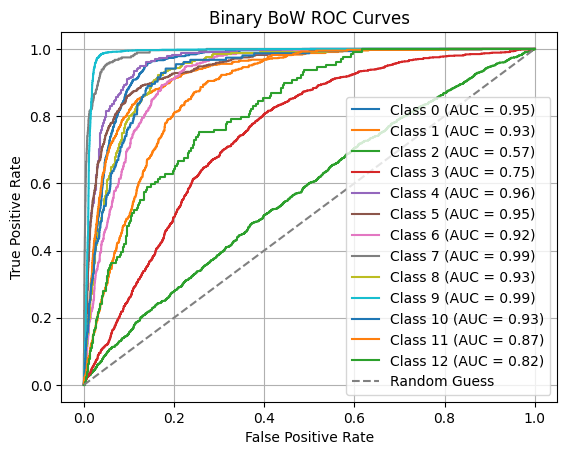

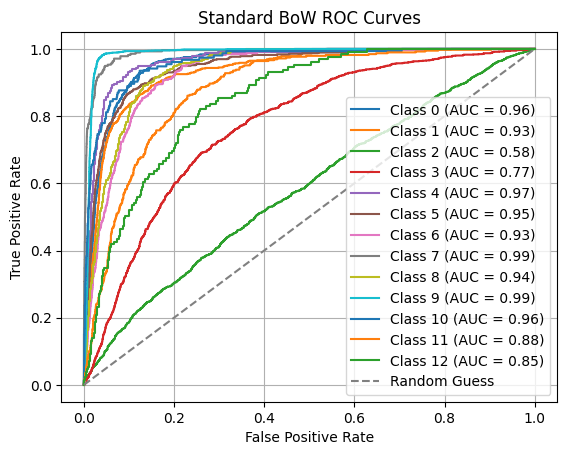

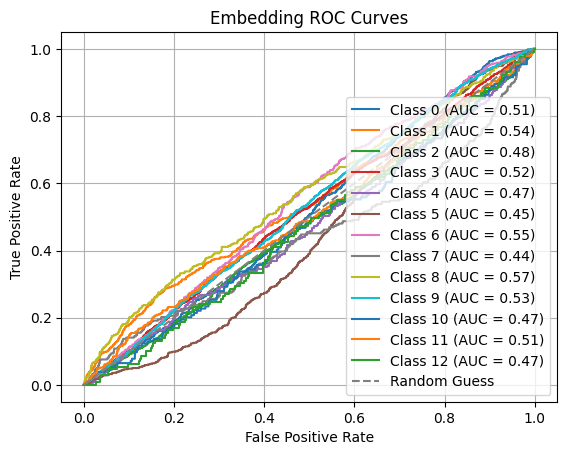

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Function to compute ROC curve and AUC score for multiple classes
def plot_roc_curves(outputs, targets, title='ROC Curves'):
    lb = LabelBinarizer()
    targets_bin = lb.fit_transform(targets)

    fpr = dict()
    tpr = dict()
    auc = dict()

    for i in range(targets_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(targets_bin[:, i], outputs[:, i])
        auc[i] = roc_auc_score(targets_bin[:, i], outputs[:, i])

        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc_curves(binary_bow_outputs, binary_bow_targets, title='Binary BoW ROC Curves')
plot_roc_curves(standard_bow_outputs, standard_bow_targets, title='Standard BoW ROC Curves')
plot_roc_curves(embedding_outputs, embedding_targets, title='Embedding ROC Curves')